In [ ]:
[![Open in Colab](https://colab.research.google.com/assets/olab-badgge.svg)](https://colab.research.google.com/github/store-sales/blob/main/EDA.ipynb)

# Import Libraries

In [1]:
# All imports, setup logging and get configuration file

from utils import get_configuration_file, setup_logging, impute_null_values
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor

setup_logging()
config = get_configuration_file()

/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_57035/2621307173.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Import and Preprocessing

In [3]:
# Importing data

holiday_events = pd.read_csv(config["holiday_events_data_location"])
oil = pd.read_csv(config["oil_data_location"])
sample_submission = pd.read_csv(config["sample_submission_data_location"])
stores = pd.read_csv(config["stores_data_location"])
test = pd.read_csv(config["test_data_location"])
train = pd.read_csv(config["train_data_location"])
transactions = pd.read_csv(config["transactions_data_location"])

In [4]:
# Impute null values in oil prices table

oil.rename(columns={"dcoilwtico":"oil_price"},inplace = True)

for index in range(len(oil)):
    if np.isnan(oil.loc[index, "oil_price"]):
        above_oil_price_index = oil["oil_price"][:index].last_valid_index()
        below_oil_price_index = oil["oil_price"][index:].first_valid_index()
        if above_oil_price_index is not None and below_oil_price_index is not None:
            above_oil_price_value = oil.loc[above_oil_price_index, "oil_price"]
            below_oil_price_value = oil.loc[below_oil_price_index, "oil_price"]
            oil.loc[index, "oil_price"] = (above_oil_price_value+below_oil_price_value)/2
        if above_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[above_oil_price_index]
        if below_oil_price_index is not None:
            oil.loc[index, "oil_price"] = oil["oil_price"].iloc[below_oil_price_index]
        
        

In [5]:
# Add holiday column in holiday_events file and rename columns

stores.rename(columns={"type":"store_type"}, inplace = True)
holiday_events.rename(columns={"type":"holiday_type"}, inplace = True)
holiday_events["holiday"] = np.where((holiday_events["holiday_type"].
                                      isin(["Holiday","Transfer","Event",
                                           "Bridge","Additional"]) &
                                     (holiday_events["transferred"]==False)),1,0)
holiday_events_national = holiday_events[holiday_events["locale"]=="National"]

In [6]:
# Merging data

# Merging with Oil data
training_dataset = train.merge(stores, on = "store_nbr", how = "inner")
training_dataset = training_dataset.merge(oil, on = "date", how = "left")

# Merging with holiday events
training_dataset_temp = training_dataset.merge(holiday_events[["date","locale_name",
                                                               "holiday"]], how = "left",
                                                                right_on = 
                                                                ["date","locale_name"], 
                                                                left_on = ["date","city"])
training_dataset_temp.rename(columns={"holiday":"local_holiday"},inplace=True)
training_dataset_temp.drop(columns="locale_name",inplace=True)

training_dataset_temp = training_dataset_temp.merge(holiday_events_national
                                                    [["date","holiday"]],how = "left", 
                                                    left_on = "date", right_on = "date")
training_dataset_temp.rename(columns={"holiday":"national_holiday"},inplace=True)

training_dataset_temp.fillna({"local_holiday":0,"national_holiday":0},inplace = True)

training_dataset = training_dataset_temp

# training_dataset

In [7]:
# Change data types

training_dataset["date"] = pd.to_datetime(training_dataset["date"])

In [8]:
# Add features of day of week and month of year

training_dataset["dayOfWeek"] = training_dataset["date"].apply(lambda x: x.day_of_week)
training_dataset["monthOfYear"] = training_dataset["date"].apply(lambda x: x.month)

In [112]:
# Impute Null values

training_dataset = impute_null_values(training_dataset, "oil_price")


In [125]:
# Save the training dataset

training_dataset.to_csv("training_dataset.csv",index=False)

In [126]:
training_dataset.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
oil_price           0
local_holiday       0
national_holiday    0
dayOfWeek           0
monthOfYear         0
dtype: int64

In [127]:
training_dataset.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'oil_price', 'local_holiday',
       'national_holiday', 'dayOfWeek', 'monthOfYear'],
      dtype='object')

In [128]:
training_dataset.describe()

id                           date     store_nbr  \
count  3.008280e+06                        3008280  3.008280e+06   
mean   1.501579e+06  2015-04-24 23:47:40.728390144  2.750037e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.520698e+05            2014-02-28 00:00:00  1.400000e+01   
50%    1.502358e+06            2015-04-26 00:00:00  2.800000e+01   
75%    2.249081e+06            2016-06-19 00:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.657256e+05                            NaN  1.558533e+01   

              sales   onpromotion       cluster     oil_price  local_holiday  \
count  3.008280e+06  3.008280e+06  3.008280e+06  3.008280e+06   3.008280e+06   
mean   3.582643e+02  2.609735e+00  8.481395e+00  6.780945e+01   4.036858e-03   
min    0.000000e+00  0.000000e+00  1.000000e+00  2.619000e+01   0.000000e+00   
25%    0.000000e+00  0.000000e+00  4.000000e+00  4.629000e+01   0.000000e+00   
50%    1.100000e+01  0.000000e+00  8.500000e+00  5.319000e+01   0.000000e+00   
75%    1.960000e+02  0.000000e+00  1.300000e+01  9.580000e+01   0.000000e+00   
max    1.247170e+05  7.410000e+02  1.700000e+01  1.106200e+02   1.000000e+00   
std    1.103486e+03  1.226302e+01  4.649769e+00  2.569562e+01   6.340791e-02   

       national_holiday     dayOfWeek   monthOfYear  
count      3.008280e+06  3.008280e+06  3.008280e+06  
mean       7.996928e-02  3.002633e+00  6.209193e+00  
min        0.000000e+00  0.000000e+00  1.000000e+00  
25%        0.000000e+00  1.000000e+00  3.000000e+00  
50%        0.000000e+00  3.000000e+00  6.000000e+00  
75%        0.000000e+00  5.000000e+00  9.000000e+00  
max        1.000000e+00  6.000000e+00  1.200000e+01  
std        2.712457e-01  2.001885e+00  3.384834e+00

In [129]:
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3008280 entries, 0 to 3008279
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                int64         
 1   date              datetime64[ns]
 2   store_nbr         int64         
 3   family            object        
 4   sales             float64       
 5   onpromotion       int64         
 6   city              object        
 7   state             object        
 8   store_type        object        
 9   cluster           int64         
 10  oil_price         float64       
 11  local_holiday     float64       
 12  national_holiday  float64       
 13  dayOfWeek         int64         
 14  monthOfYear       int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(4)
memory usage: 431.7+ MB


# Data Visualization

In [388]:
# Plot pairplot

# sns.pairplot(training_dataset)
# plt.show()

# # plt.savefig("Visualizations/Pairplot.png")

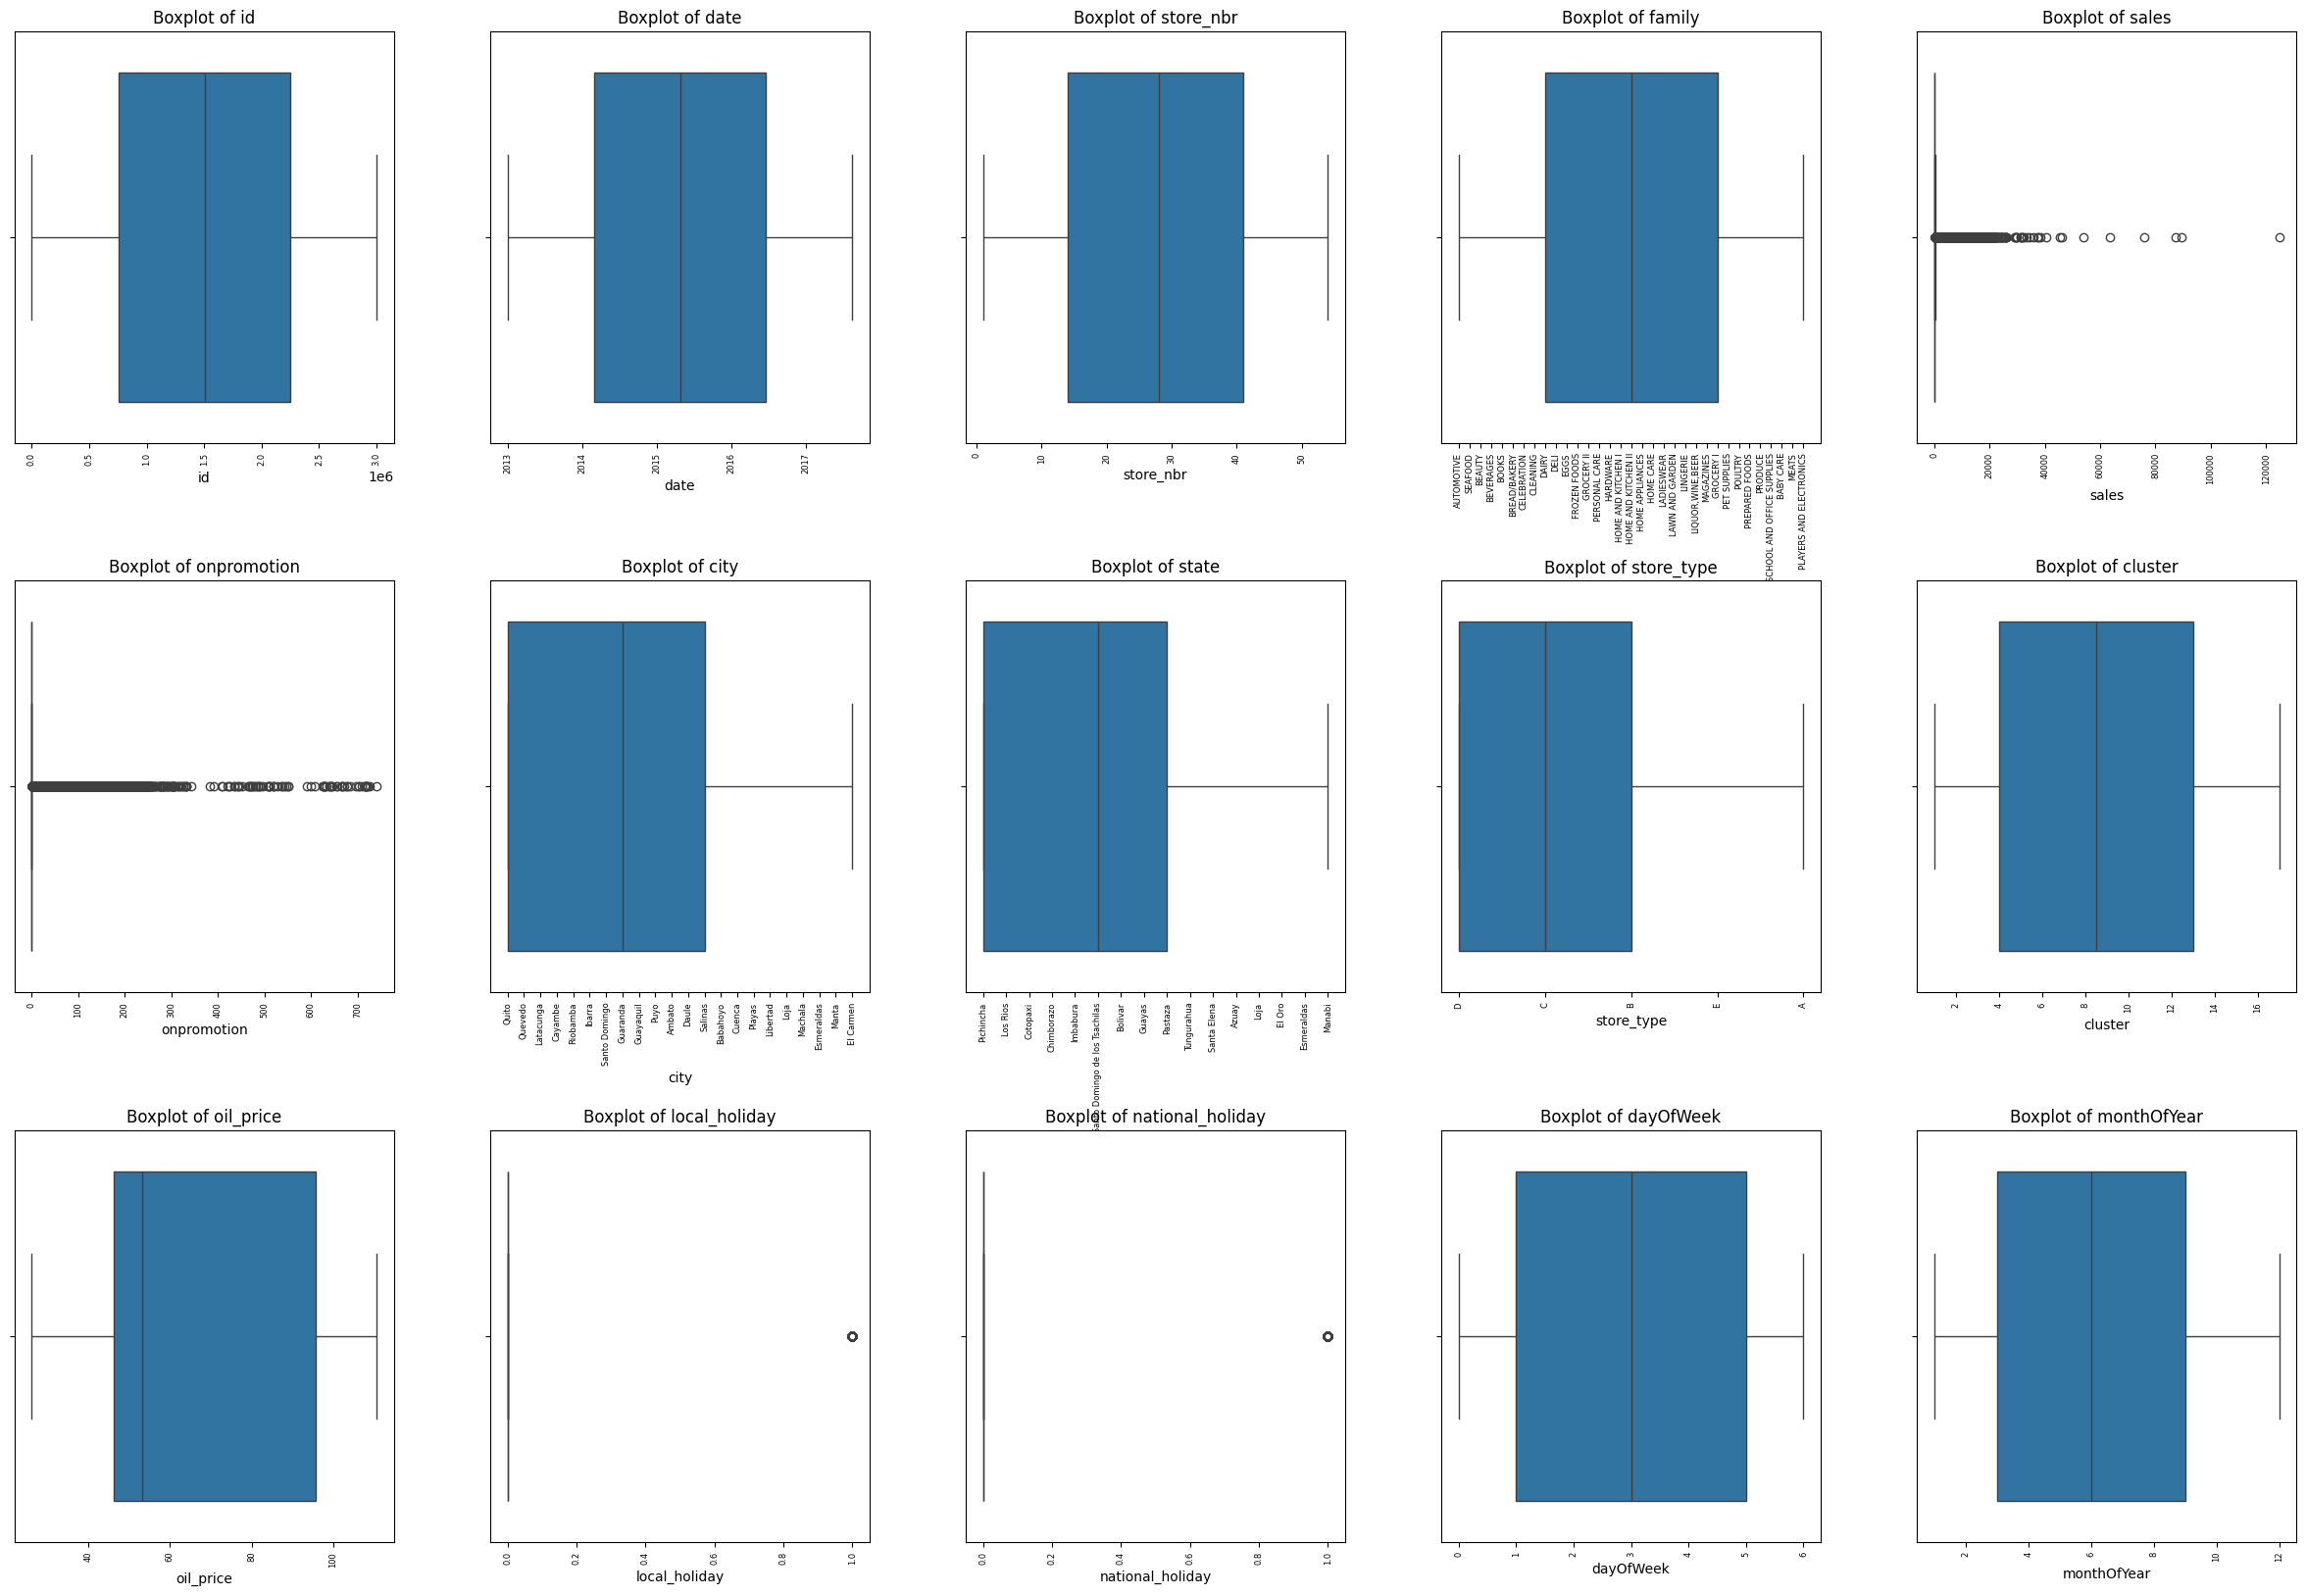

In [405]:
# Plot boxplot to check outliers

# fig, ax = plt.subplots(3,5,figsize=(24, 16))
# fig.tight_layout(h_pad=8,w_pad=4)

# for column in training_dataset.columns:
#     row_num = int(list(training_dataset.columns).index(column)/5)
#     col_num = list(training_dataset.columns).index(column)%5
#     sns.boxplot(x=training_dataset[column],ax=ax[row_num][col_num])
#     ax[row_num][col_num].tick_params(axis='x',rotation=90, labelsize=6)
#     ax[row_num][col_num].set_title(f'Boxplot of {column}')

# plt.show()

# # plt.savefig("Visualizations/Boxplots.png")


/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
/var/folders/t2/rv4p8zx13gj6mt8wcy_ckn3w0000gn/T/ipykernel_19148/1681338815.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)


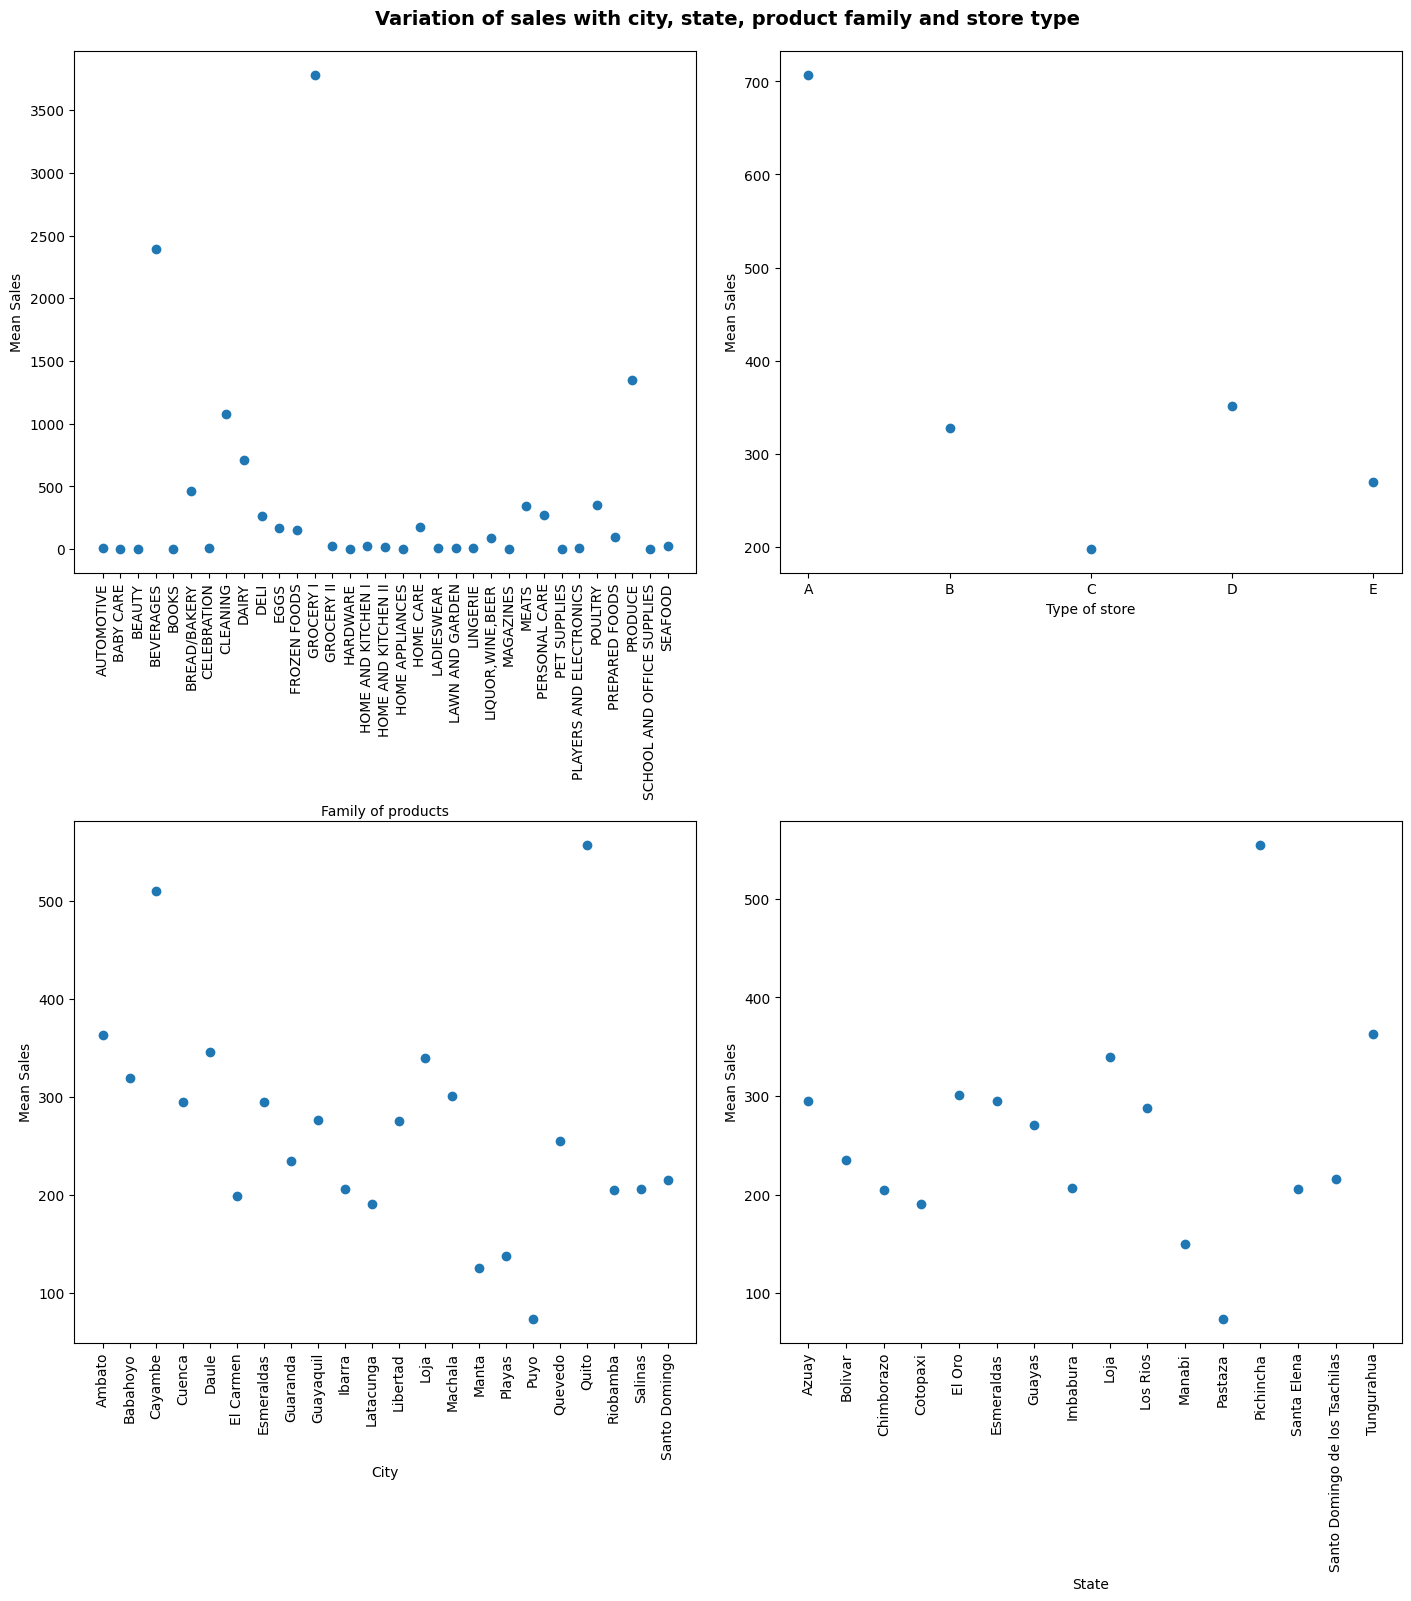

In [16]:
fig, ax = plt.subplots(2,2, figsize = (14,14))
fig.suptitle("Variation of sales with city, state, product family and store type", size = 14, 
             weight = "bold")

fig.tight_layout(h_pad = 16, w_pad = 3)

groupby_column = "family"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(),rotation = 90)
ax[0,0].set_xlabel("Family of products")
ax[0,0].set_ylabel("Mean Sales")

groupby_column = "store_type"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[0,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[0,1].set_xlabel("Type of store")
ax[0,1].set_ylabel("Mean Sales")

groupby_column = "city"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,0].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(),rotation = 90)
ax[1,0].set_xlabel("City")
ax[1,0].set_ylabel("Mean Sales")

groupby_column = "state"
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
ax[1,1].scatter(x = grouped[groupby_column], y = grouped["sales"])
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(),rotation = 90)
ax[1,1].set_xlabel("State")
ax[1,1].set_ylabel("Mean Sales")

plt.subplots_adjust(top=0.95)

# plt.savefig('Visualizations/Sales scatter plots .png')

In [76]:
groupby_column = ["store_nbr","family"]
grouped = training_dataset.groupby(groupby_column)
grouped = grouped.agg({"sales":"mean"}).reset_index()
grouped

store_nbr                      family        sales
0             1                  AUTOMOTIVE     3.249408
1             1                   BABY CARE     0.000000
2             1                      BEAUTY     2.408768
3             1                   BEVERAGES  1587.809834
4             1                       BOOKS     0.125000
...         ...                         ...          ...
1777         54                     POULTRY    52.835036
1778         54              PREPARED FOODS    61.226303
1779         54                     PRODUCE   354.878766
1780         54  SCHOOL AND OFFICE SUPPLIES     0.626185
1781         54                     SEAFOOD     1.742891

[1782 rows x 3 columns]

# Data Preparation for modelling

In [8]:
# Import data
training_dataset = pd.read_csv("training_dataset.csv")
training_dataset["date"] = pd.to_datetime(training_dataset["date"])
training_dataset = training_dataset.sort_values(by = "date")
print("Number of columns in dataset: ", len(training_dataset.columns))
training_dataset.columns

Number of columns in dataset:  15


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'oil_price', 'local_holiday',
       'national_holiday', 'dayOfWeek', 'monthOfYear'],
      dtype='object')

In [9]:
# Check for one particular store and family of product

# training_dataset = training_dataset[(training_dataset["store_nbr"]==1)&(training_dataset["family"]=="AUTOMOTIVE")]

# # X = training_dataset[["onpromotion","oil_price","local_holiday","national_holiday","dayOfWeek","monthOfYear"]]
# X = training_dataset[["onpromotion","oil_price"]]
# y = training_dataset["sales"]

# training_dataset_plot = training_dataset[training_dataset["date"]<pd.to_datetime('01-01-2014')]
# plt.figure(figsize=(18,8))
# plt.plot(training_dataset_plot["date"], training_dataset_plot["sales"])
# plt.show()

# X = pd.get_dummies(X, columns = ["dayOfWeek","monthOfYear"], dtype = int)

# X.drop(columns = ["dayOfWeek_0","monthOfYear_1"], inplace = True)

# X_dropped_sparsity = X

# print (len(X.columns))
# X.columns


In [4]:
# Divide data into X and y

X = training_dataset[config["training_columns"]]
y = training_dataset["sales"]
print("Number of columns in training dataset: ",len(X.columns))
X.columns

Number of columns in training dataset:  12


Index(['store_nbr', 'family', 'onpromotion', 'store_type', 'cluster', 'city',
       'state', 'oil_price', 'local_holiday', 'national_holiday', 'dayOfWeek',
       'monthOfYear'],
      dtype='object')

### One Hot encoding

In [5]:
# One hot categorical columns

X = pd.get_dummies(X, columns = config["categorical_columns"], dtype = int)

X.drop(columns = config["encoded_columns_drop"], inplace = True)
print("Number of columns in training dataset: ",len(X.columns))
X.columns

Number of columns in training dataset:  162


Index(['onpromotion', 'oil_price', 'local_holiday', 'national_holiday',
       'store_nbr_2', 'store_nbr_3', 'store_nbr_4', 'store_nbr_5',
       'store_nbr_6', 'store_nbr_7',
       ...
       'monthOfYear_3', 'monthOfYear_4', 'monthOfYear_5', 'monthOfYear_6',
       'monthOfYear_7', 'monthOfYear_8', 'monthOfYear_9', 'monthOfYear_10',
       'monthOfYear_11', 'monthOfYear_12'],
      dtype='object', length=162)

### Sparsity based filtering

In [7]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

94.64730533029251

In [6]:
# Drop columns based on sparsity in X

sparsity_column_threshold = config["sparsity_column_threshold"]

sparsity_column_wise = pd.DataFrame({"columnName":[],"sparsityPercent":[]})

for column in X.columns:
    non_zero_cells_count = np.count_nonzero(X[column])
    total_cells_count = X[column].size
    sparsity_column = (1-(non_zero_cells_count/total_cells_count))
    sparsity_column_wise = sparsity_column_wise._append({"columnName":column,"sparsityPercent":
                                                         sparsity_column}, ignore_index=True)

sparsity_column_wise.sort_values(by="sparsityPercent", ascending = False, inplace=True)
columns_to_drop = sparsity_column_wise[sparsity_column_wise["sparsityPercent"]>
                                       sparsity_column_threshold]["columnName"].tolist()

print("Columns dropped: ",columns_to_drop)
X_dropped_sparsity = X.drop(columns_to_drop, axis=1)
len(X_dropped_sparsity.columns)


Columns dropped:  ['local_holiday']


161

In [7]:
# Calculate statistics on X
correlation_matrix = X_dropped_sparsity.corr()
# X_dropped_sparsity_stats = X_dropped_sparsity.describe()

In [ ]:
# Checking standard deviation in each column

X_dropped_sparsity_stats.loc["std",:].sort_values(ascending=False)

oil_price                               25.695619
onpromotion                             12.263017
state_Pichincha                          0.477539
store_type_D                             0.471402
city_Quito                               0.471394
state_Guayas                             0.402803
store_type_A                             0.372675
city_Guayaquil                           0.355321
store_type_B                             0.355245
dayOfWeek_6                              0.350521
dayOfWeek_1                              0.350432
dayOfWeek_5                              0.350432
dayOfWeek_4                              0.349828
dayOfWeek_3                              0.349222
dayOfWeek_2                              0.349222
cluster_3                                0.335907
cluster_10                               0.314298
cluster_6                                0.314271
monthOfYear_5                            0.291263
cluster_15                               0.289849


[]

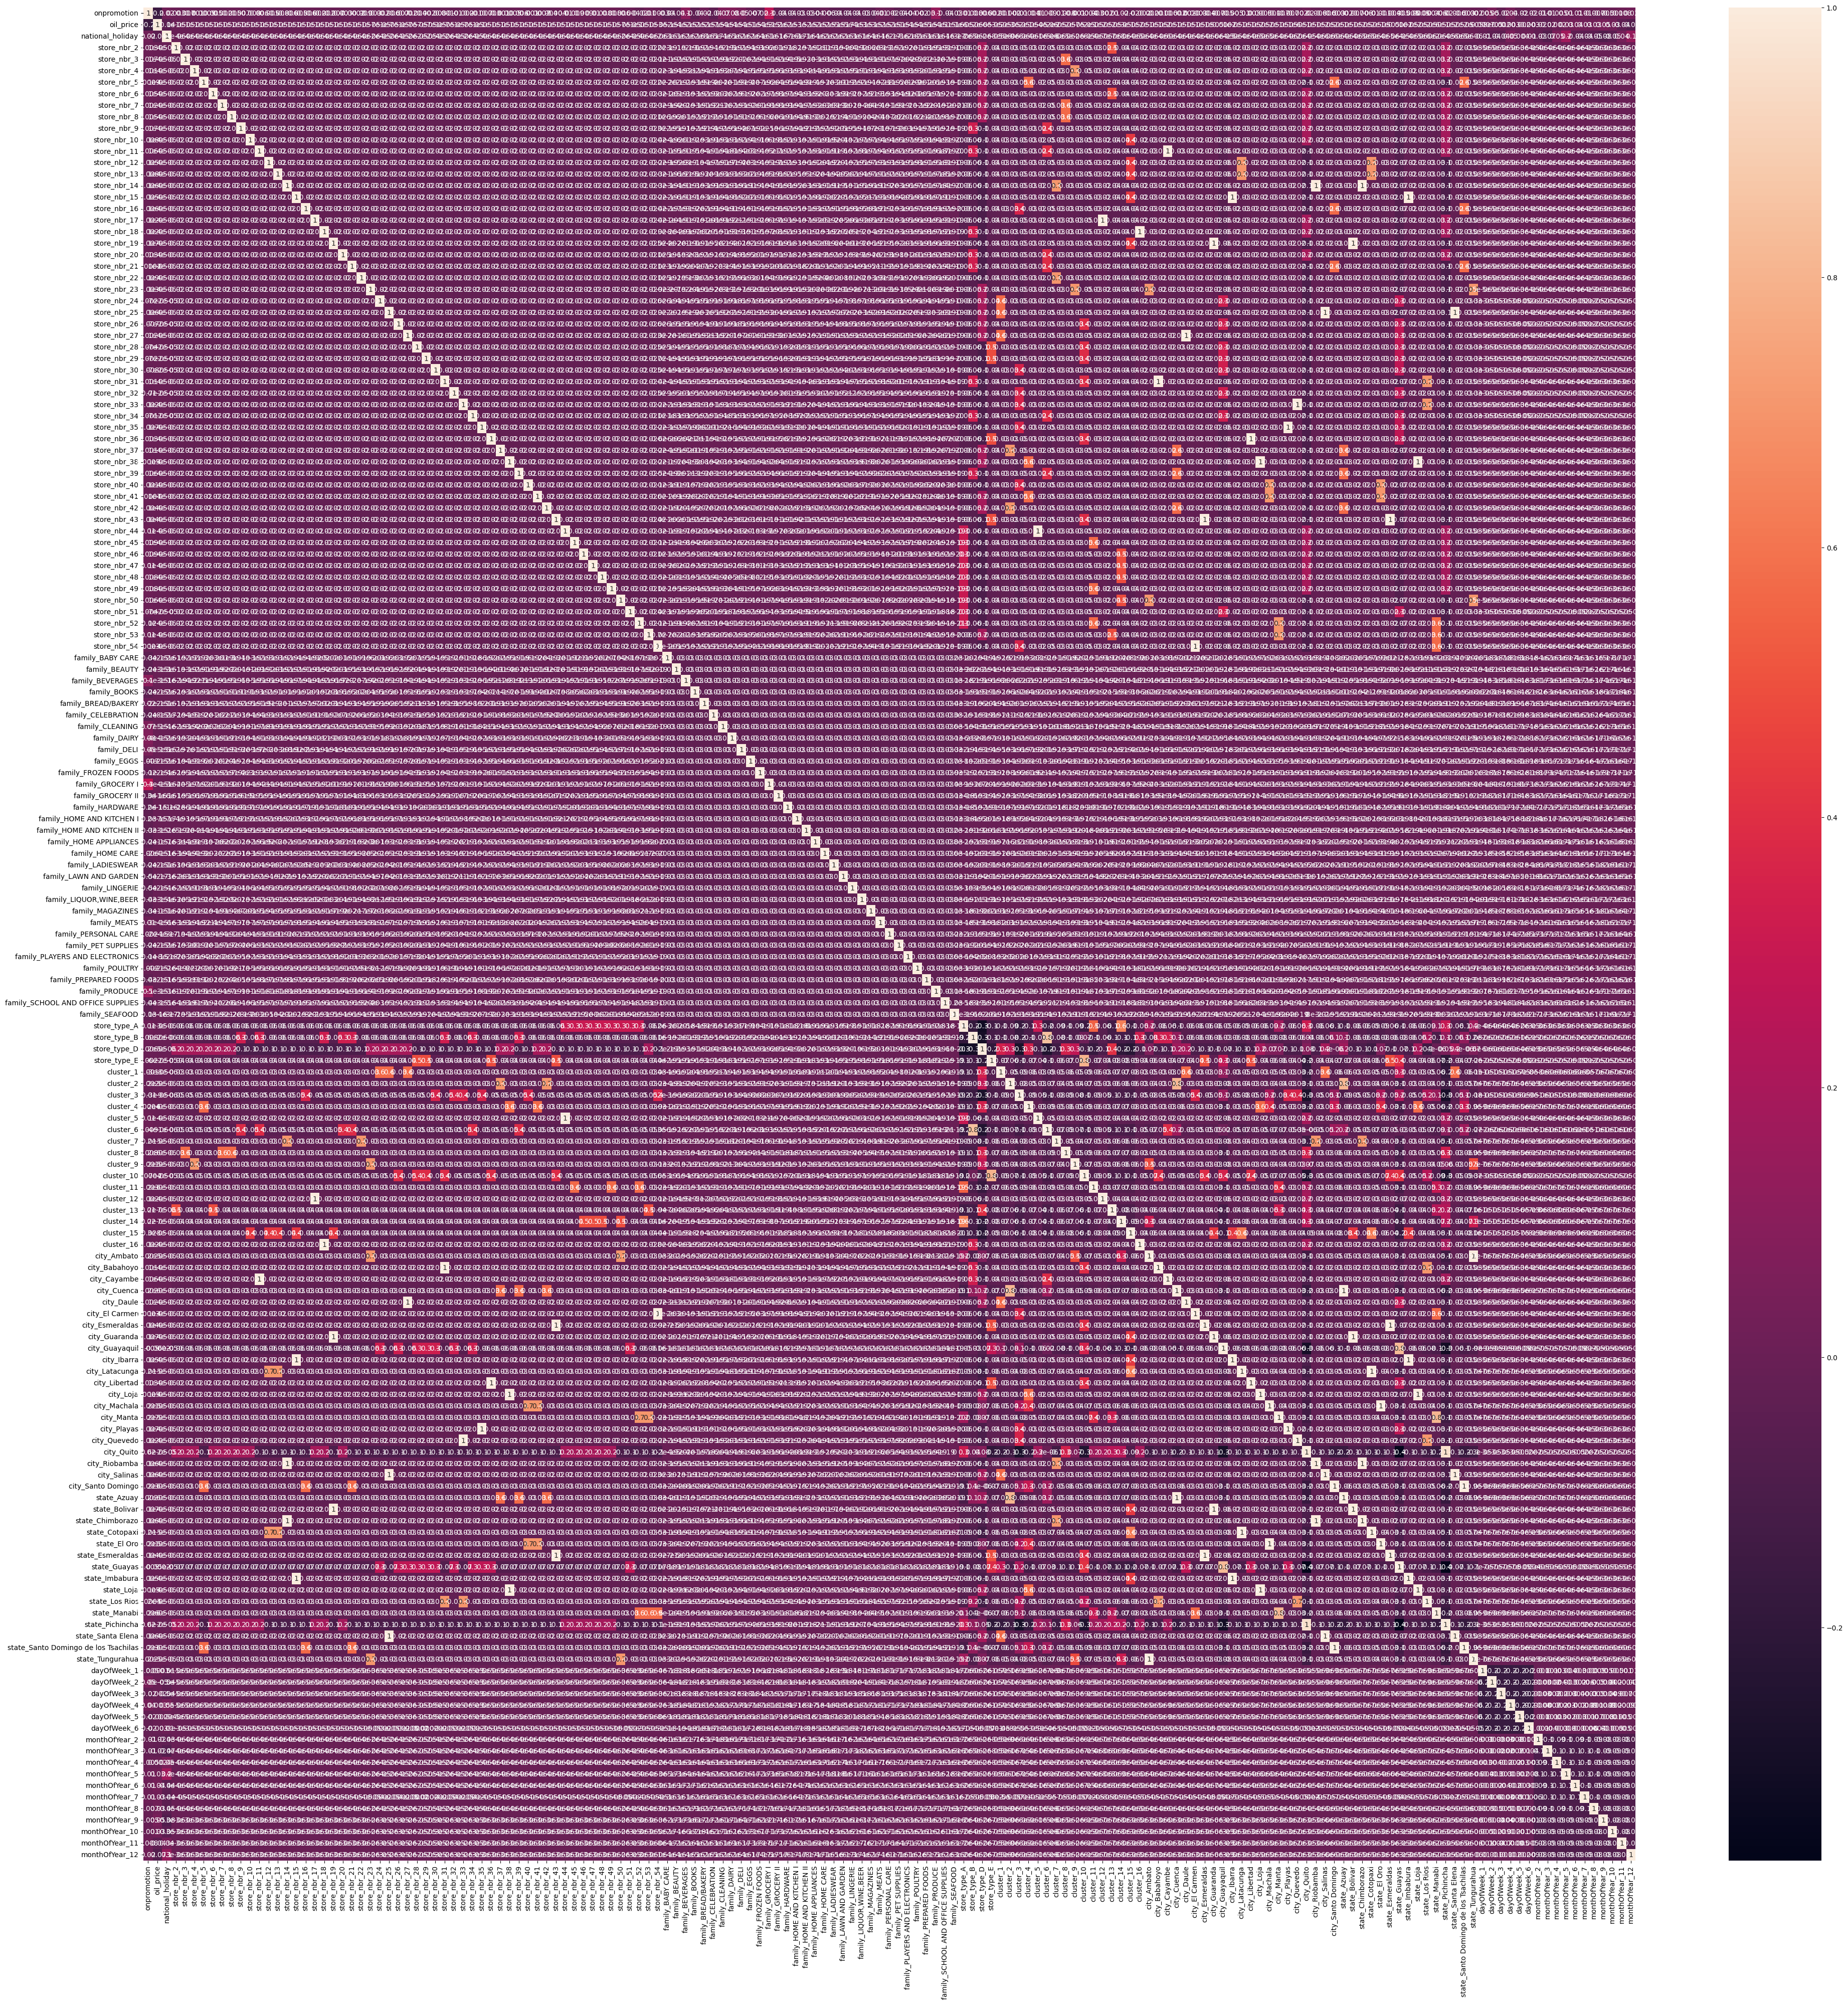

In [8]:
# Plot correlation heatmap
plt.figure(figsize=(48,48))
sns.heatmap(correlation_matrix, annot = True, fmt = '.1g')
plt.plot()

# plt.savefig('Visualizations/Correlation plot.png')

In [9]:
# Drop highly correlated features

correlation_matrix_absolute = correlation_matrix.abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix_absolute.where(np.triu(np.ones(correlation_matrix_absolute.shape),
                                                   k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = config["correlation_threshold"]
columns_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print("The columns to be dropped are: ", columns_to_drop)

# Drop features 
X_dropped_sparsity_correlation = X_dropped_sparsity.drop(columns_to_drop, axis=1)

print(len(X_dropped_sparsity_correlation.columns))

The columns to be dropped are:  ['cluster_5', 'cluster_12', 'cluster_16', 'city_Babahoyo', 'city_Cayambe', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Ibarra', 'city_Libertad', 'city_Loja', 'city_Playas', 'city_Quevedo', 'city_Riobamba', 'city_Salinas', 'state_Azuay', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas', 'state_Imbabura', 'state_Loja', 'state_Pichincha', 'state_Santa Elena', 'state_Santo Domingo de los Tsachilas', 'state_Tungurahua']
133


In [10]:
correlations_with_target = pd.DataFrame({"columnName":[],"correlation":[]})
for column in X_dropped_sparsity_correlation.columns:
    correlation = {"columnName":column,"correlation":X_dropped_sparsity_correlation[column].corr(y)}
    correlations_with_target = correlations_with_target._append(correlation, ignore_index=True)

correlations_with_target.sort_values(by="correlation", ascending=False)

columnName  correlation
67        family_GROCERY I     0.548334
0              onpromotion     0.427505
58        family_BEVERAGES     0.325481
85          family_PRODUCE     0.159244
88            store_type_A     0.141296
..                     ...          ...
94               cluster_3    -0.057240
72  family_HOME APPLIANCES    -0.057320
56        family_BABY CARE    -0.057376
59            family_BOOKS    -0.057382
1                oil_price    -0.075155

[133 rows x 2 columns]

In [16]:
# Calculate sparsity of feature matrix
non_zero_cells_count = np.count_nonzero(X)
total_cells_count = X_dropped_sparsity_correlation.size
sparsity = (1-(non_zero_cells_count/total_cells_count))*100
sparsity

93.48017641734877

In [11]:
# X_dropped_sparsity_correlation.to_csv('datasets_temporary/X_dropped_sparsity_correlation.csv',index=False)

## Feature scaling

In [2]:
# Import data

# training_dataset = pd.read_csv("training_dataset.csv")
# training_dataset["date"] = pd.to_datetime(training_dataset["date"])
# training_dataset = training_dataset.sort_values(by = "date")
# y = training_dataset["sales"]

# X_dropped_sparsity_correlation = pd.read_csv("datasets_temporary/X_dropped_sparsity_correlation.csv")
# X_dropped_sparsity_correlation.drop(columns="Unnamed: 0",axis=1,inplace=True)

# print(training_dataset.shape)
# print(X_dropped_sparsity_correlation.shape)
# print(X_dropped_sparsity_correlation.columns)

# Perform standard scaling

standardscaler = StandardScaler()
X_dropped_sparsity_correlation_scaled = standardscaler.fit_transform(X_dropped_sparsity_correlation)
X_dropped_sparsity_correlation_scaled

array([[-0.21281348,  0.98579263,  3.3918728 , ..., -0.28156061,
        -0.2766286 , -0.27786744],
       [-0.21281348,  0.98579263,  3.3918728 , ..., -0.28156061,
        -0.2766286 , -0.27786744],
       [-0.21281348,  0.98579263,  3.3918728 , ..., -0.28156061,
        -0.2766286 , -0.27786744],
       ...,
       [-0.13126746, -0.78766173, -0.29482238, ..., -0.28156061,
        -0.2766286 , -0.27786744],
       [-0.21281348, -0.78766173, -0.29482238, ..., -0.28156061,
        -0.2766286 , -0.27786744],
       [-0.21281348, -0.78766173, -0.29482238, ..., -0.28156061,
        -0.2766286 , -0.27786744]])

# Baseline

In [42]:
# Using 3 day moving average

# training_dataset = training_dataset[(training_dataset["store_nbr"]==1)&(training_dataset["family"]=="AUTOMOTIVE")]

# y = training_dataset[["date","sales"]]
# y["predict_sales"] = y["sales"].rolling(window=3).mean().shift(1)
# y.dropna(inplace=True)

# print("R-squared error using moving average of 3 previous days is: ",r2_score(y["sales"],y["predict_sales"]))


# Model training

In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X_dropped_sparsity_correlation_scaled, y, test_size = 0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.25)

In [4]:
print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)
print("X_test shape: ",X_test.shape)

X_train shape:  (1804968, 133)
X_val shape:  (601656, 133)
X_test shape:  (601656, 133)


## Linear Regression

In [8]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
model_linear.score(X_train, y_train)

0.5639530350446424

Feature importances are: [357.37825030322324, 206.16635831549686, -49.86438152945277, 10.67910146194307, 18.27016882705867, 20029295731373.36, -19216794861143.305, 1854686493501.106, 24.52020505981048, 20029295731320.527, 20029295731328.117, 13784850940406.82, -14200773273286.316, 15537568865622.549, 2598289859065.5786, 2598289859065.7993, 14921097345241.293, -12448055348071.957, 3716766394764.968, -381220990270.8081, 4142552706037.989, -12448055348068.514, 13784850940370.139, 23128102567489.914, 14921097345221.643, -5455408027679.848, -18361270872737.08, -29130062784378.58, 7937183475053.679, -25639774745039.62, 6181190919087.023, 6181190919064.033, 6902363443997.597, -23829206210231.105, 6902363443994.578, -31926167889434.85, 26319340059220.875, -383479267836.8218, -1104442299164.5815, -37511838602530.766, -5735847208408.807, 4870453750962.873, -2672805111250.982, -4534885012532.476, -37511838602563.91, -4594730338485.259, -4241134634765.759, -8344193499521.992, -3175741568270.8027, 

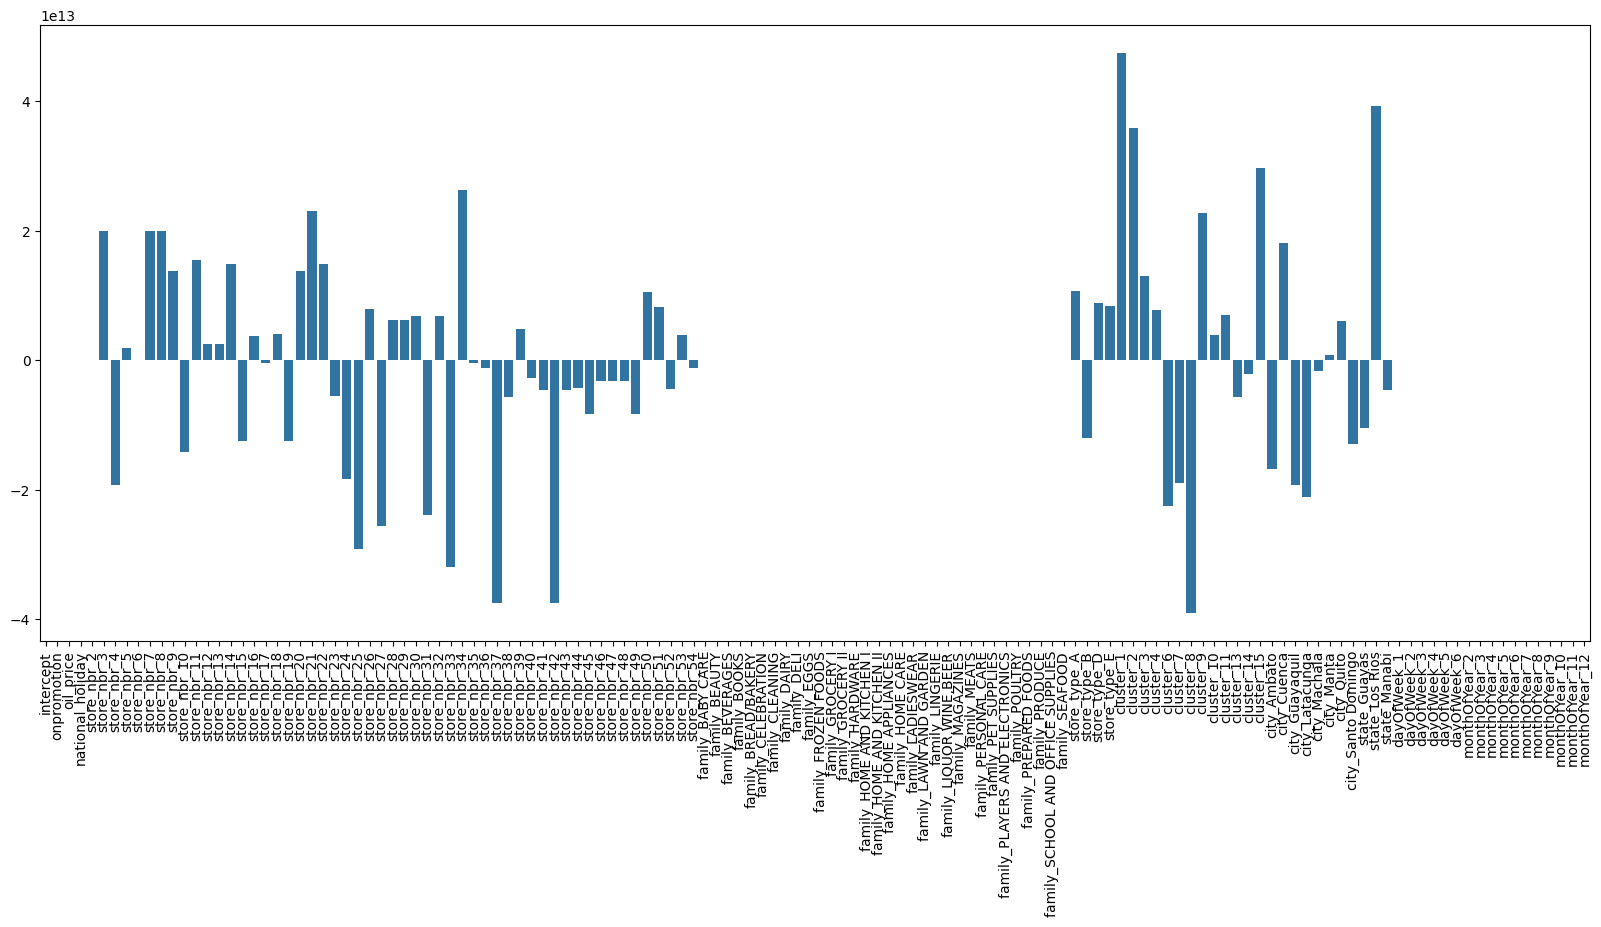

In [9]:
# Get feature importance for linear regression

feature_names = list(X_dropped_sparsity_correlation.columns)
feature_names.insert(0,'intercept')

coeffecients = list(model_linear.coef_)
coeffecients.insert(0,model_linear.intercept_)

print(f'Feature importances are: {coeffecients}')

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

Sparsities are:  [79.5907295863417, 0.0, 92.00307152259764, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.14721369021501, 98.1483106625713, 98.14721369021501, 98.1483106625713, 98.14721369021501, 98.14721369021501, 98.14721369021501, 98.1483106625713, 98.14721369021501, 98.1483106625713, 98.14721369021501, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.1483106625713, 98.14721369021501, 98.1483106625713, 98.14831066257

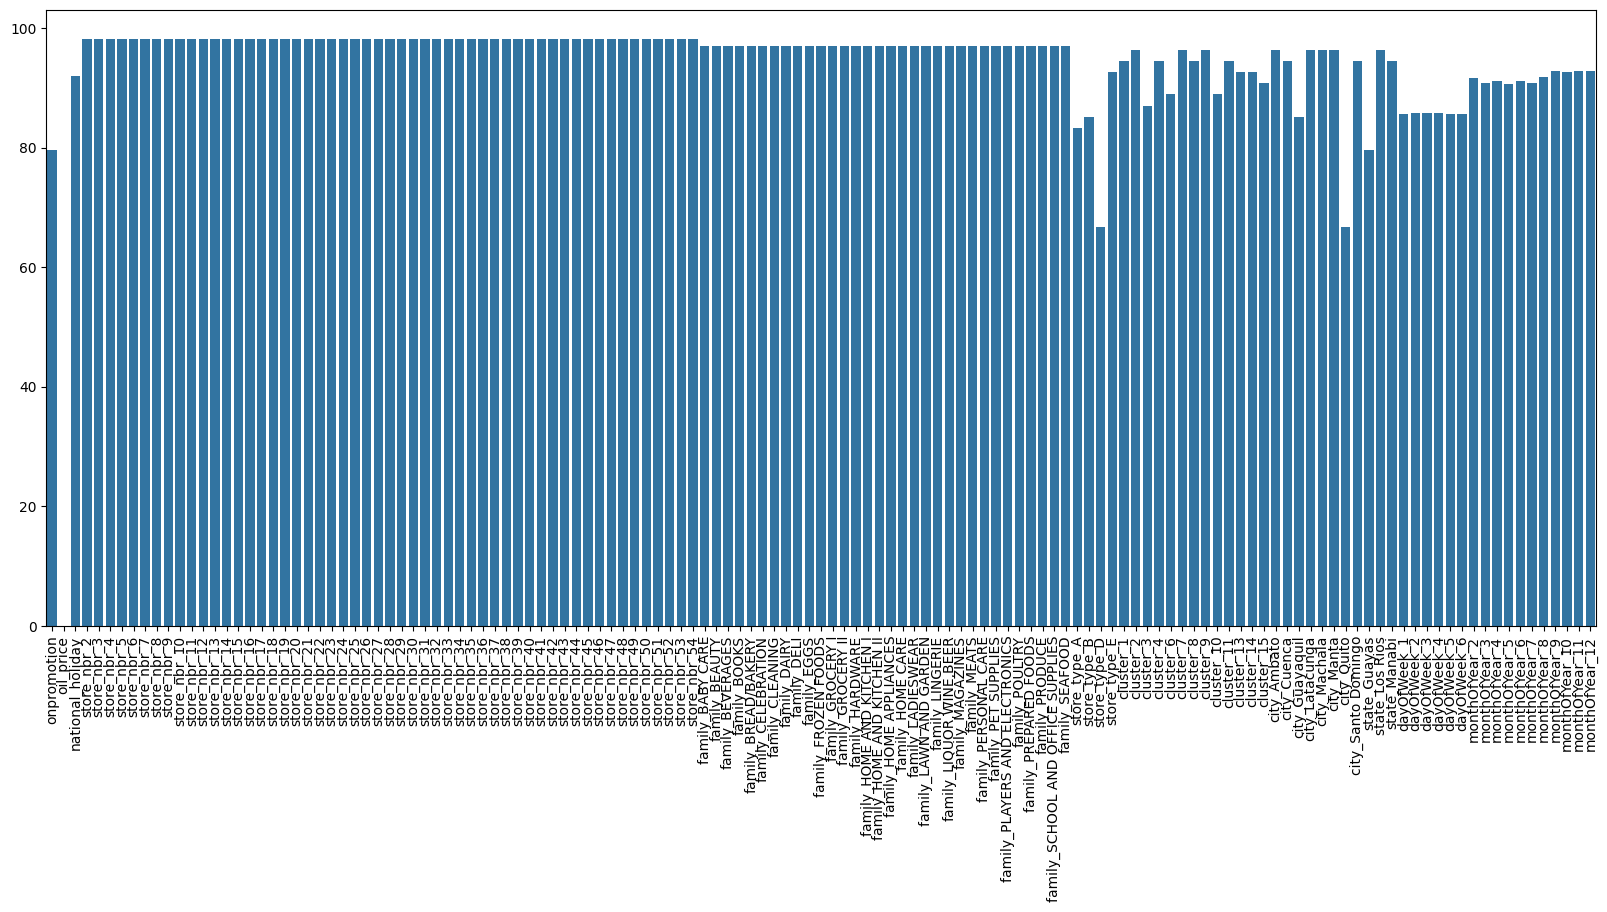

In [10]:
# Calculate sparsity in each column

sparsities=[]
total_cells_count = X_dropped_sparsity_correlation.shape[0]

for column in X_dropped_sparsity_correlation.columns:
    non_zero_cells_count = np.count_nonzero(X_dropped_sparsity_correlation[column])
    sparsity = (1-(non_zero_cells_count/total_cells_count))*100
    sparsities.append(sparsity)

print("Sparsities are: ",sparsities)


# Get feature importance for linear regression

feature_names = list(X_dropped_sparsity_correlation.columns)

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=sparsities)
plt.xticks(rotation=90)
plt.show()


In [16]:
model_linear.score(X_val, y_val)

0.5697185714954459

In [17]:
y_train_pred = model_linear.predict(X_train)
y_val_pred = model_linear.predict(X_val)
y_test_pred = model_linear.predict(X_test)

Residual plot - Linear regression

Sum of errors is:  -92517.51052870243
Standard deviation of errors is:  680.5592359271146


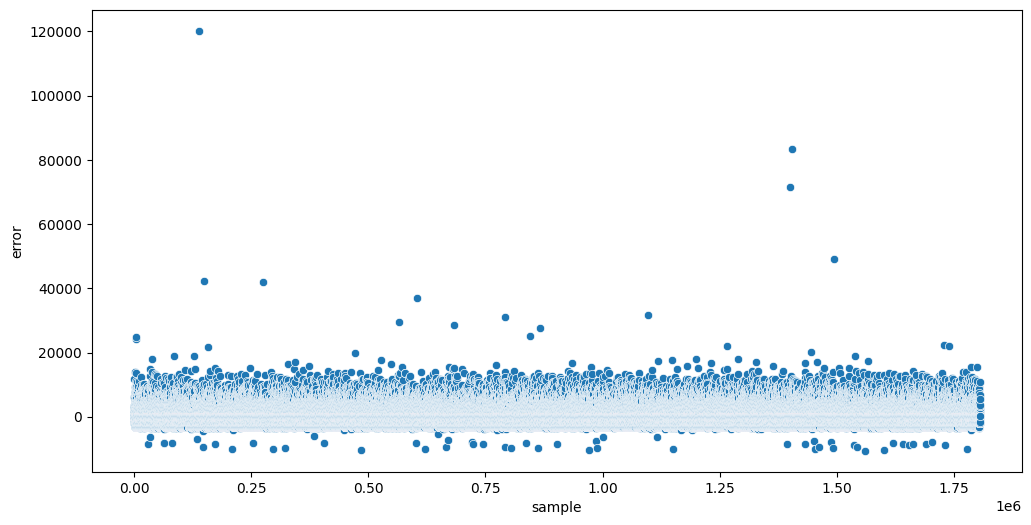

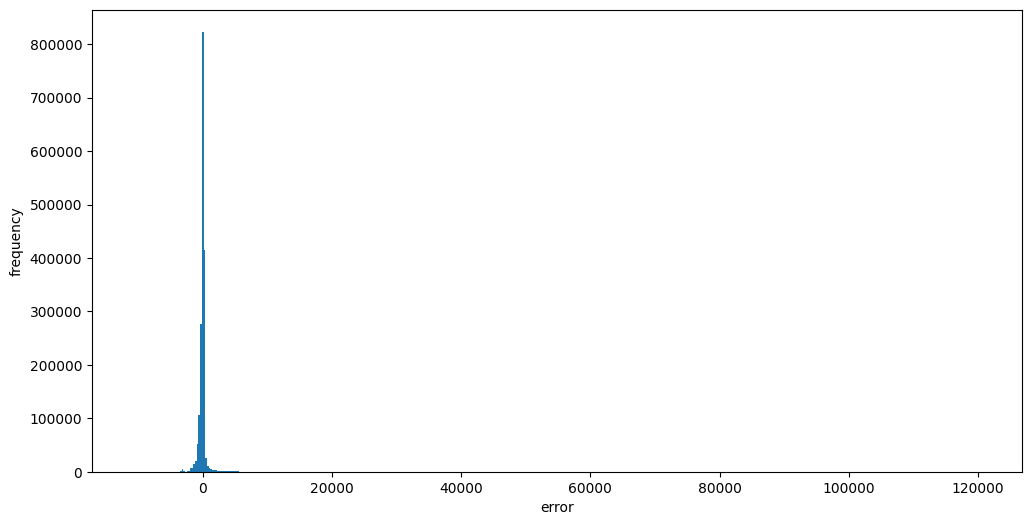

In [18]:
print("Sum of errors is: ",np.sum(y_train-y_train_pred))
print("Standard deviation of errors is: ",np.std(y_train-y_train_pred))

plt.figure(figsize=(12,6))
sns.scatterplot(x=np.arange(len(y_train)),y=y_train-y_train_pred)
plt.xlabel("sample")
plt.ylabel("error")
plt.show()

plt.figure(figsize=(12,6))
plt.hist(y_train-y_train_pred,bins=500)
plt.xlabel("error")
plt.ylabel("frequency")
plt.show()



## Lasso Regression

In [5]:
model_linear_lasso = Lasso()
params = [{'alpha':np.logspace(-4,3,12)}]
# params = [{'alpha':[0.0001,0.001,0.01,0.0005]}]
timeseriescv = TimeSeriesSplit(n_splits=5)

gridsearch = GridSearchCV(model_linear_lasso, params, cv=timeseriescv, return_train_score=True, n_jobs=-1, verbose=10)
gridsearch.fit(X_train,y_train)

print("Best parameter is : alpha = ",gridsearch.best_params_)
print("Best model score on training set is ",gridsearch.best_score_)


Fatal Python error: init_sys_streams: can't initialize sys standard streams
Python runtime state: core initialized
OSError: [Errno 9] Bad file descriptor

Current thread 0x0000000204fb32c0 (most recent call first):
  <no Python frame>


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

/opt/anaconda3/envs/kaggle_store_sales/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.153e+10, tolerance: 1.905e+08
  model = cd_fast.enet_coordinate_descent(


Feature importances are: [373.29821736353693, 73.57264870066683, 200.6752607565618, 0.9152675601242916, 8.050365928080195, 16.631663125439133, 71.01613733175923, -0.8235647341650824, -7.564394062637918, 24.669914699179667, 18.489011205958455, 26.06836157372482, 15.981482727128881, -17.4996406427564, 19.96478693081989, -16.397302093954664, -15.78637571959503, -16.425969921317552, -14.956020494813442, -15.999501188009122, -2.4414940594764647, -11.646164388116397, -10.950688090367436, -20.64525728193926, -26.07902317699574, -35.40722633648071, -16.811897302293342, 8.502085607676344, -17.588774751783046, -25.431200699238854, -2.4928511584097084, -9.16697577973822, -32.36946336028991, -29.05321091081842, -7.2015324313351945, -31.951118234641243, -13.638052196354696, -4.679976848550389, -28.347509231221128, -15.51633914909083, -4.835823508549572, -3.4622350452502912, -2.5032994623384575, -8.53735099883489, -17.38180189739641, -36.15688203028486, -12.313748698619378, 95.40498667348463, 76.183

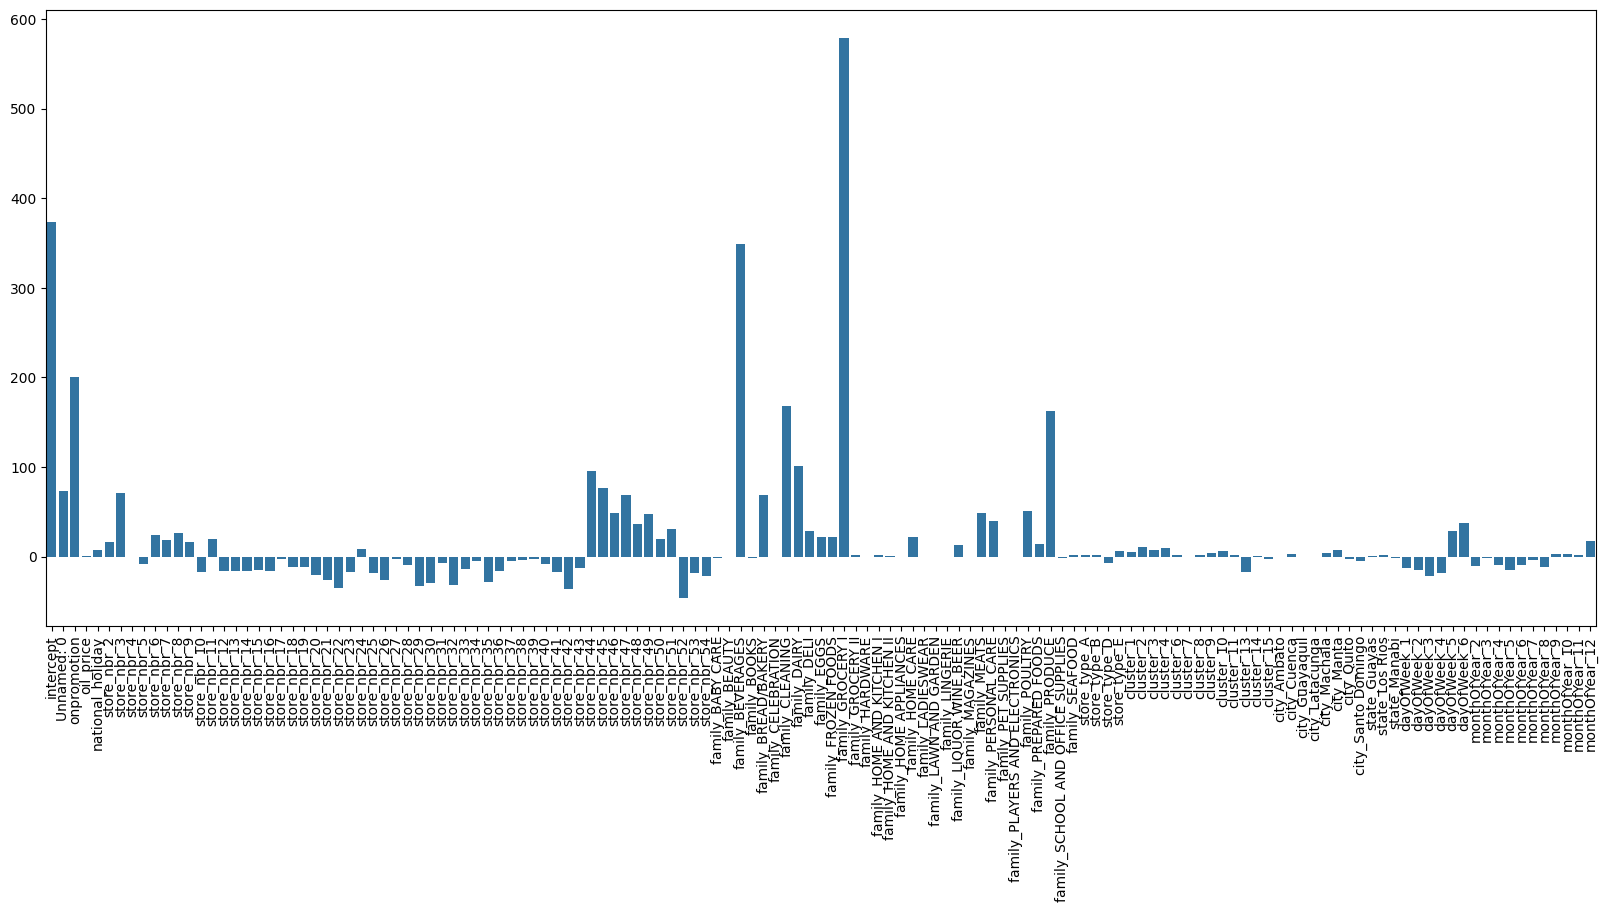

In [34]:
model_linear_lasso = Lasso(gridsearch.best_params_['alpha'])
model_linear_lasso.fit(X_train, y_train)

# Get feature importance for lasso linear regression

feature_names = list(X_dropped_sparsity_correlation.columns)
feature_names.insert(0,'intercept')

coeffecients = list(model_linear_lasso.coef_)
coeffecients.insert(0,model_linear_lasso.intercept_)

print(f'Feature importances are: {coeffecients}')

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

In [35]:
model_linear_lasso.score(X_val, y_val)

0.5688011575157554

In [36]:
y_train_pred = model_linear_lasso.predict(X_train)
y_val_pred = model_linear_lasso.predict(X_val)
y_test_pred = model_linear_lasso.predict(X_test)

Residual plot - Lasso Linear regression

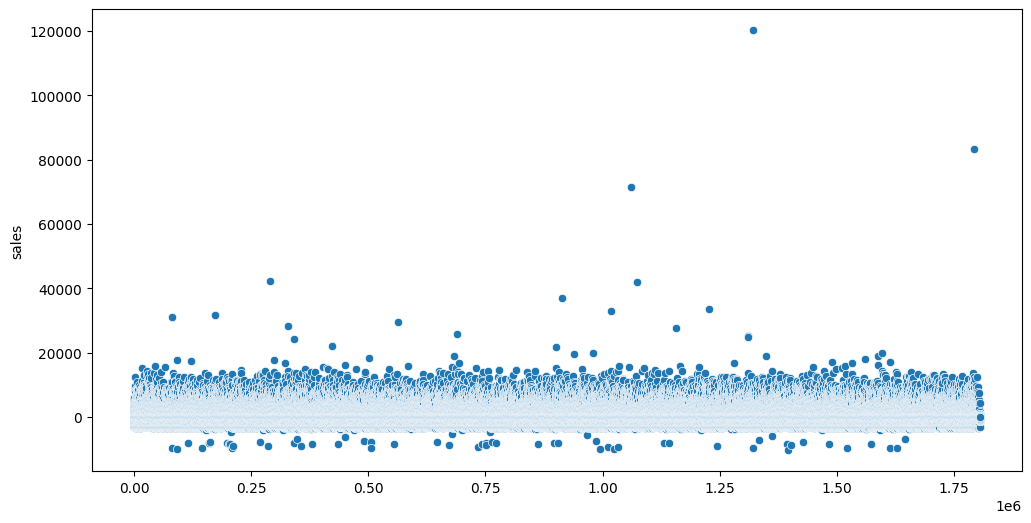

In [37]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=np.arange(len(y_train)),y=y_train-y_train_pred)
plt.show()

## Ridge Regression

In [24]:
model_linear_ridge = Ridge()
params = [{'alpha':np.logspace(-4,3,8)}]
# params = [{'alpha':[0.0001, 0.00215, 0.00464, 0.01]}]
timeseriescv = TimeSeriesSplit(n_splits=5)

gridsearch = GridSearchCV(model_linear_ridge, params, cv=timeseriescv, return_train_score=True, n_jobs=1, verbose=10)
gridsearch.fit(X_train,y_train)

print("Best parameter is : alpha = ",gridsearch.best_params_)
print("Best model score on training set is ",gridsearch.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START alpha=0.0001................................................
[CV 1/5; 1/8] END alpha=0.0001;, score=(train=0.575, test=0.573) total time=   2.0s
[CV 2/5; 1/8] START alpha=0.0001................................................
[CV 2/5; 1/8] END alpha=0.0001;, score=(train=0.574, test=0.568) total time=   2.3s
[CV 3/5; 1/8] START alpha=0.0001................................................
[CV 3/5; 1/8] END alpha=0.0001;, score=(train=0.572, test=0.568) total time=   3.1s
[CV 4/5; 1/8] START alpha=0.0001................................................
[CV 4/5; 1/8] END alpha=0.0001;, score=(train=0.571, test=0.572) total time=   4.8s
[CV 5/5; 1/8] START alpha=0.0001................................................
[CV 5/5; 1/8] END alpha=0.0001;, score=(train=0.571, test=0.563) total time=   7.3s
[CV 1/5; 2/8] START alpha=0.001.................................................
[CV 1/5; 2/8] END alpha=0.001;, sc

Feature importances are: [355.97784636323115, 201.23582176873478, -50.08721362001912, 10.478013453055823, 16.422715396336542, 48.127655011168066, -1.1395056820650502, 3.1564197314293483, 24.252582275222846, -3.5232395620813963, 4.031334041005648, 11.706919828971051, -18.096089054669598, 24.770346304310763, -4.2763116649016295, -3.9103986708362806, -1.9849164160100277, -6.673521257106196, -0.6661567297916808, -8.653535359488277, -15.870819411951373, -2.8467234225971505, -24.844340722138227, -18.8083690175404, -21.591069737981805, -4.435571644555564, 16.621188830409302, -14.286252362193315, -12.703686224673254, 3.7203389116673984, 8.197037898183346, -15.267223408291802, -12.337613031097307, 3.0433929649062876, -15.274594123006368, -1.3283600143589605, 4.588866673109494, -13.43963535102322, 0.047646882035378084, 11.966440464405315, 4.4382885026245065, 5.121954593367333, 6.735997018206014, -6.708937092643638, -19.535054949596237, 0.5351722143233429, 71.44100865918708, 44.74771173914816, 13

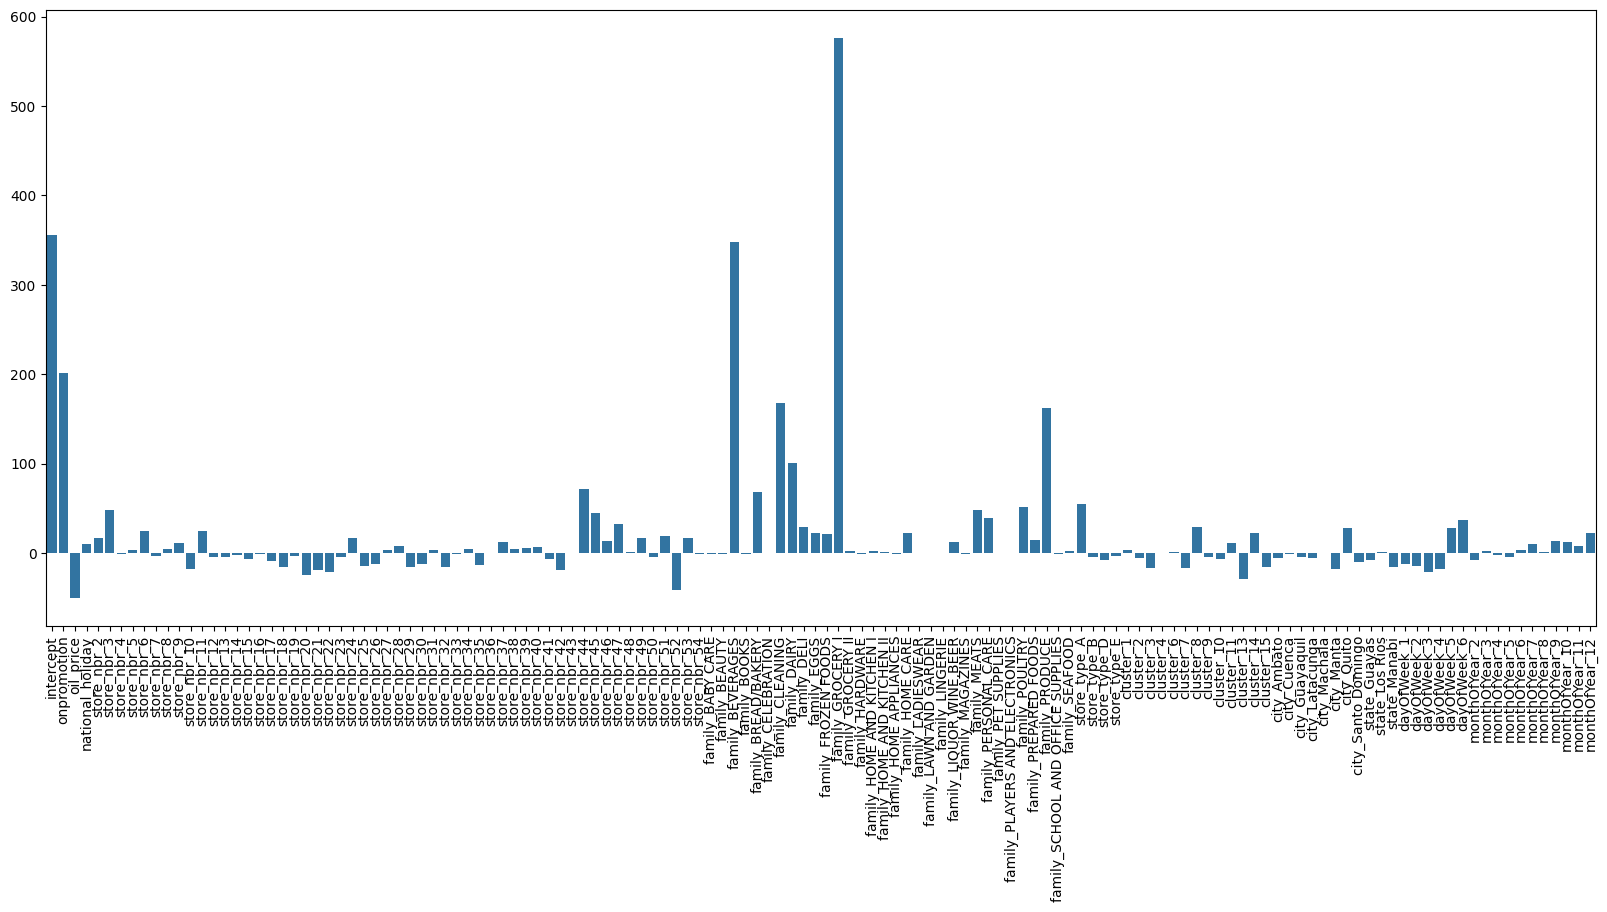

In [25]:
model_linear_ridge = Ridge(gridsearch.best_params_['alpha'])
model_linear_ridge.fit(X_train,y_train)

# Get feature importance for lasso linear regression

feature_names = list(X_dropped_sparsity_correlation.columns)
feature_names.insert(0,'intercept')

coeffecients = list(model_linear_ridge.coef_)
coeffecients.insert(0,model_linear_ridge.intercept_)

print(f'Feature importances are: {coeffecients}')

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

In [26]:
model_linear_ridge.score(X_val, y_val)

0.5524990182723519

In [27]:
y_train_pred = model_linear_ridge.predict(X_train)
y_val_pred = model_linear_ridge.predict(X_val)
y_test_pred = model_linear_ridge.predict(X_test)

Residual plot - Ridge Linear Regression

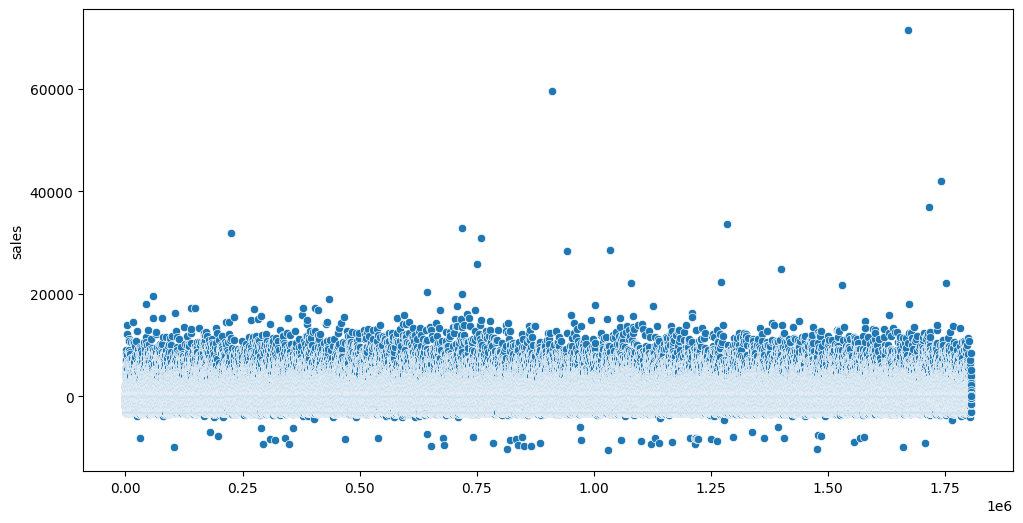

In [28]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=np.arange(len(y_train)),y=y_train-y_train_pred)
plt.show()

## Decision Tree

In [29]:
model_dt = DecisionTreeRegressor()
params=[{'max_depth': [50,70,100],
         'min_samples_split': [100, 500, 1000]}]

timeseriescv = TimeSeriesSplit(n_splits=5)

gridsearch = GridSearchCV(model_dt, params, cv=timeseriescv, return_train_score=True, n_jobs=1)
gridsearch.fit(X_train,y_train)

print("Best parameter is : alpha = ",gridsearch.best_params_)
print("Best model score on training set is ",gridsearch.best_score_)

Best parameter is : alpha =  {'max_depth': 70, 'min_samples_split': 100}
Best model score on training set is  0.8967263622198649


Feature importances are: [0.0666503998599906, 0.02993635937247615, 0.003210646382476287, 0.0008048506140627233, 0.024015054315185625, 0.00025803708163592775, 0.00011602497602185397, 0.0017482093022881087, 0.0001303609572558041, 0.0007599005744384099, 0.004019795320108629, 0.00046936297763728837, 0.0059663917723808595, 7.241189170166586e-05, 2.1639176260213186e-05, 0.000182495901742622, 6.892070561163253e-05, 3.4556600193015e-05, 0.0006082709678071881, 0.0003486538829238473, 0.00043245046220276615, 0.0030238293391779553, 0.002660434508056158, 0.0024768733281336284, 0.000768990540496357, 0.0014131590112762505, 0.000882926643645269, 0.0012350156610782708, 0.00037486099170703444, 0.0003383317970073666, 0.002596738432595079, 3.0668643509036034e-05, 0.00017638168283692468, 0.00012162163821851618, 8.538363741980455e-05, 7.417385623849739e-05, 8.200628220834605e-05, 0.00010152538387713249, 0.00032846675090018017, 0.0006504243514520665, 0.00014603855648086112, 0.0016641308425129047, 6.609878324

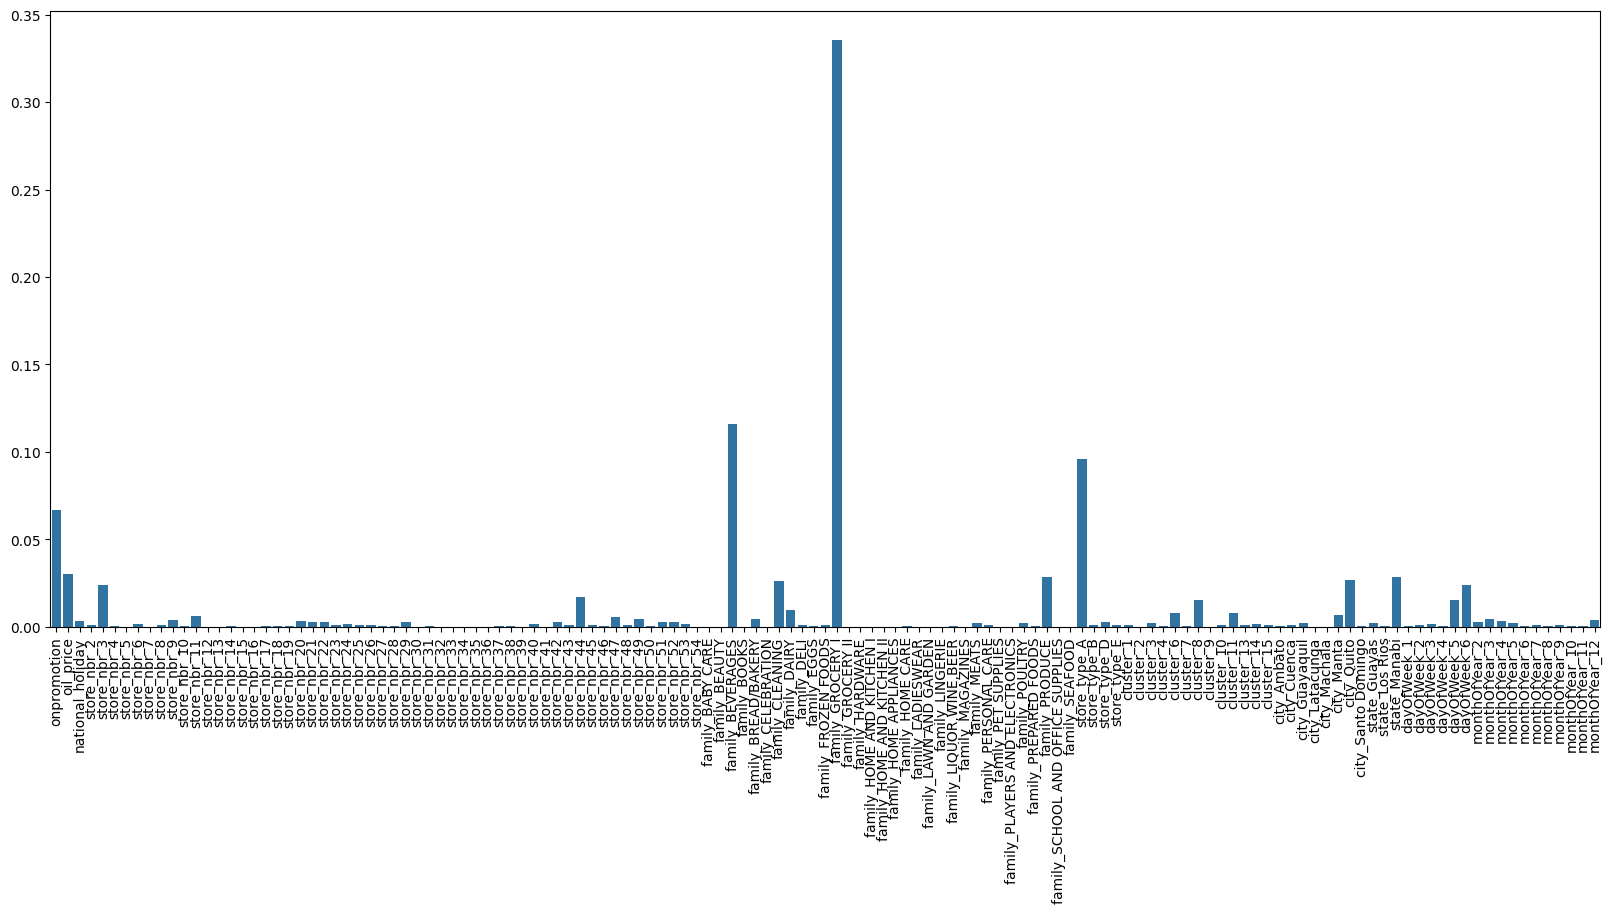

In [30]:
model_dt = DecisionTreeRegressor(**gridsearch.best_params_)
model_dt.fit(X_train,y_train)

# Get feature importance for decision trees

feature_names = list(X_dropped_sparsity_correlation.columns)
# feature_names.insert(0,'intercept')

coeffecients = list(model_dt.feature_importances_)
# coeffecients.insert(0,model_dt.intercept_)

print(f'Feature importances are: {coeffecients}')

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

In [31]:
model_dt.score(X_val,y_val)

0.8844055797440709

In [32]:
y_train_pred = model_dt.predict(X_train)
y_val_pred = model_dt.predict(X_val)
y_test_pred = model_dt.predict(X_test)

## Random Forest

In [38]:
model_rf = RandomForestRegressor()
# params = [{'n_estimators':[50,100,120],
#            'max_depth': [20,40,60],
#            'min_samples_split': [100, 500, 1000]}]
params = [{'n_estimators':[50],
           'max_depth': [60],
           'min_samples_split': [100]}]
timeseriescv = TimeSeriesSplit(n_splits=5)

gridsearch = GridSearchCV(model_rf, params, cv=timeseriescv, return_train_score=True, n_jobs=1, verbose=10)
gridsearch.fit(X_train,y_train)

print("Best parameter is : alpha = ",gridsearch.best_params_)
print("Best model score on training set is ",gridsearch.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START max_depth=60, min_samples_split=100, n_estimators=50........
[CV 1/5; 1/1] END max_depth=60, min_samples_split=100, n_estimators=50;, score=(train=0.893, test=0.886) total time= 2.5min
[CV 2/5; 1/1] START max_depth=60, min_samples_split=100, n_estimators=50........
[CV 2/5; 1/1] END max_depth=60, min_samples_split=100, n_estimators=50;, score=(train=0.914, test=0.897) total time= 5.6min
[CV 3/5; 1/1] START max_depth=60, min_samples_split=100, n_estimators=50........
[CV 3/5; 1/1] END max_depth=60, min_samples_split=100, n_estimators=50;, score=(train=0.920, test=0.903) total time= 9.0min
[CV 4/5; 1/1] START max_depth=60, min_samples_split=100, n_estimators=50........
[CV 4/5; 1/1] END max_depth=60, min_samples_split=100, n_estimators=50;, score=(train=0.923, test=0.920) total time=12.5min
[CV 5/5; 1/1] START max_depth=60, min_samples_split=100, n_estimators=50........
[CV 5/5; 1/1] END max_depth=60, min_samp

Feature importances are: [0.06712918866024373, 0.02886260172429991, 0.002647220591844962, 0.0007321647850286932, 0.02468995225132184, 0.0002633603490684363, 9.4790166053896e-05, 0.0019435510801875582, 9.569746981835405e-05, 0.0008367429772260078, 0.0033369897976230955, 0.0004296505580005426, 0.006006040798838756, 4.6480191268861645e-05, 4.3686934312637336e-05, 8.936266278035794e-05, 6.53571447776649e-05, 2.0580430459497426e-05, 0.0007178796783715958, 0.00021024043126358994, 0.00042666642595365806, 0.0027854419657737206, 0.0026384430763983324, 0.002586023535575114, 0.0004798657596202378, 0.0015100436062751655, 0.001040585530956394, 0.0015482761970170209, 0.0003917651765523742, 0.00028861269928489447, 0.0025468075185080936, 5.69620029735297e-05, 0.00025067757973283323, 0.00021919077960797322, 0.00012356807519167654, 0.00019456916606630195, 9.841916612019344e-05, 0.00012446966512621974, 0.00043836961621244693, 0.0006243187938382338, 0.00016449522686726295, 0.0016108034148878683, 8.1526791

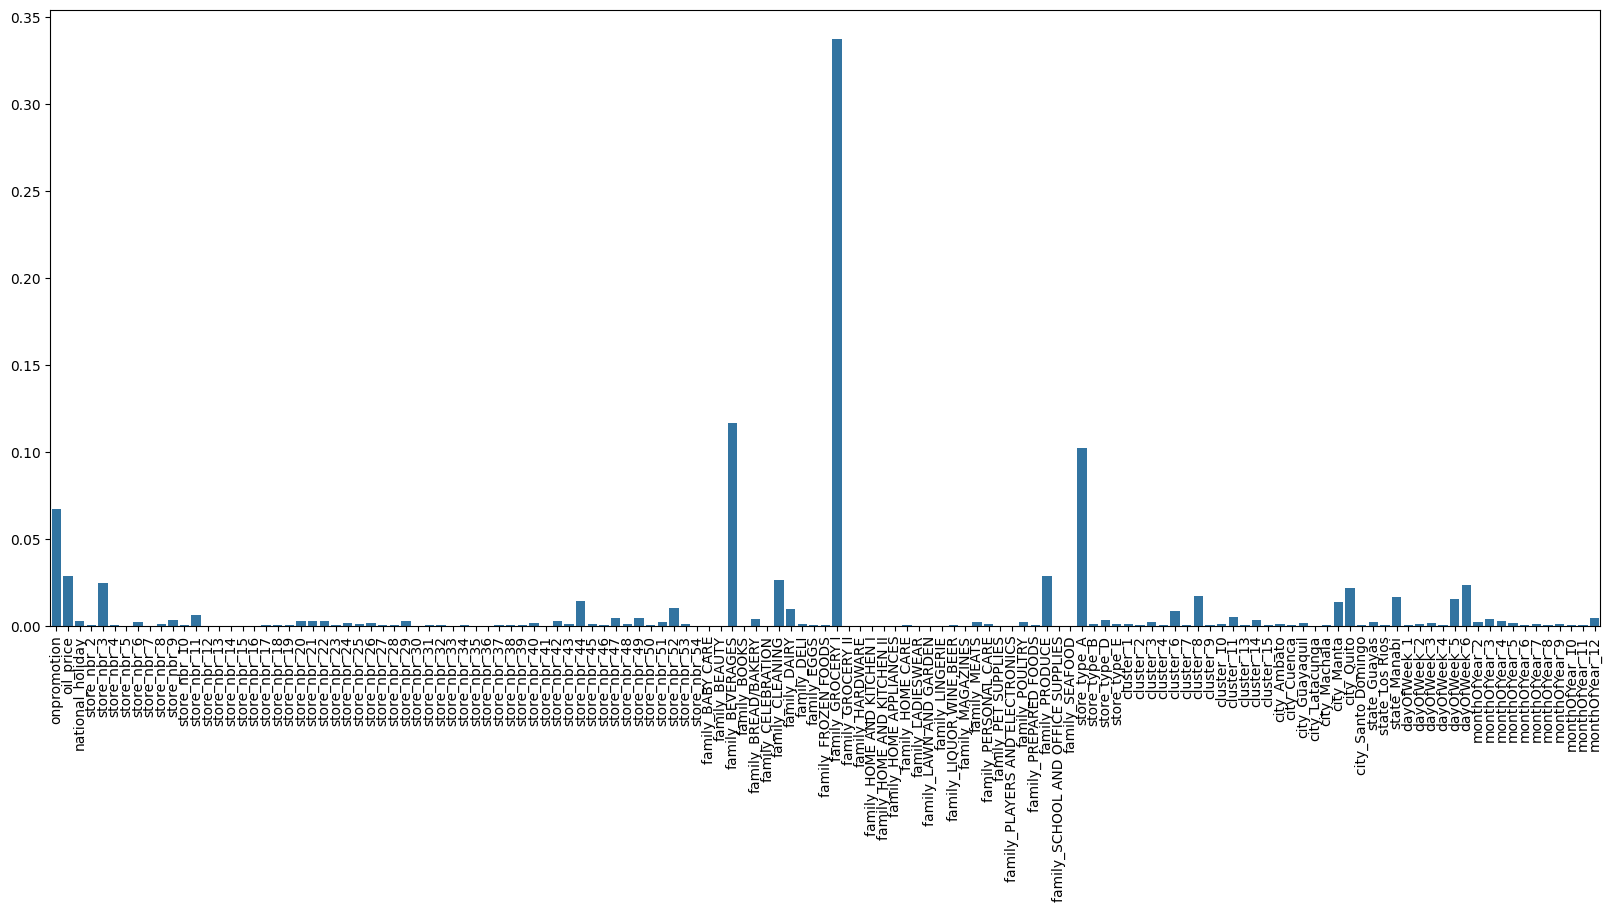

In [39]:
# best_params = {'max_depth': 60, 'min_samples_split': 100, 'n_estimators': 50}
# model_rf = RandomForestRegressor(**best_params)

model_rf = RandomForestRegressor(**gridsearch.best_params_)
model_rf.fit(X_train,y_train)

# Get feature importance for decision trees

feature_names = list(X_dropped_sparsity_correlation.columns)
# feature_names.insert(0,'intercept')

coeffecients = list(model_rf.feature_importances_)
# coeffecients.insert(0,model_dt.intercept_)

print(f'Feature importances are: {coeffecients}')

plt.figure(figsize=(20,8))
sns.barplot(x=feature_names, y=coeffecients)
plt.xticks(rotation=90)
plt.show()

In [40]:
model_rf.score(X_val, y_val)

0.8897532986277609

## Gradient Boosting

In [ ]:
# model_gb = GradientBoostingRegressor()
# model_gb.fit(X_train, y_train)
# model_gb.score(X_train, y_train)

0.38746931936620177

In [43]:
model_gb = GradientBoostingRegressor()
params = [{'n_estimators':[50,100,150],
           'max_depth': [20,40,60],
           'min_samples_split': [100, 500, 1000]}]
# params = [{'alpha':[0.0001,0.001,0.01,0.0005]}]
timeseriescv = TimeSeriesSplit(n_splits=5)

gridsearch = GridSearchCV(model_gb, params, cv=timeseriescv, return_train_score=True, n_jobs=1, verbose=10)
gridsearch.fit(X_train,y_train)

print("Best parameter is : alpha = ",gridsearch.best_params_)
print("Best model score on training set is ",gridsearch.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START max_depth=20, min_samples_split=100, n_estimators=50.......
[CV 1/5; 1/27] END max_depth=20, min_samples_split=100, n_estimators=50;, score=(train=0.963, test=0.932) total time= 3.4min
[CV 2/5; 1/27] START max_depth=20, min_samples_split=100, n_estimators=50.......
[CV 2/5; 1/27] END max_depth=20, min_samples_split=100, n_estimators=50;, score=(train=0.970, test=0.936) total time= 7.7min
[CV 3/5; 1/27] START max_depth=20, min_samples_split=100, n_estimators=50.......
[CV 3/5; 1/27] END max_depth=20, min_samples_split=100, n_estimators=50;, score=(train=0.970, test=0.938) total time=11.4min
[CV 4/5; 1/27] START max_depth=20, min_samples_split=100, n_estimators=50.......
[CV 4/5; 1/27] END max_depth=20, min_samples_split=100, n_estimators=50;, score=(train=0.969, test=0.952) total time=15.5min
[CV 5/5; 1/27] START max_depth=20, min_samples_split=100, n_estimators=50.......
[CV 5/5; 1/27] END max_depth=20, 

: 

In [ ]:
model_gb.score(X_val, y_val)

0.09643714652522406

**Looking at the problem from business point of view, sales of products in a shop should depend on following factors:**

item, city, state, location, marketing, discount, festival, price change, substitute item price,
online penetration for delivery, delivery region, competitors (shops, online) in the region, offers to customers like debt,
home delivery etc., nature of shopkeeper, salesmanship of shopkeeper, wealth of people in the region where shop is located, 


In [ ]:
training_dataset

id       date  store_nbr         family    sales  onpromotion  \
0              0 2013-01-01          1     AUTOMOTIVE    0.000            0   
1194        1194 2013-01-01         42    CELEBRATION    0.000            0   
1193        1193 2013-01-01         42   BREAD/BAKERY    0.000            0   
1192        1192 2013-01-01         42          BOOKS    0.000            0   
1191        1191 2013-01-01         42      BEVERAGES    0.000            0   
...          ...        ...        ...            ...      ...          ...   
3007085  2999693 2017-08-15         25   PET SUPPLIES    3.000            0   
3007084  2999692 2017-08-15         25  PERSONAL CARE   93.000            8   
3007083  2999691 2017-08-15         25          MEATS  180.107            0   
3007094  2999702 2017-08-15         26         BEAUTY    0.000            0   
3008279  3000887 2017-08-15          9        SEAFOOD   16.000            0   

              city        state store_type  cluster  oil_price  local_holiday  \
0            Quito    Pichincha          D       13      93.14            0.0   
1194        Cuenca        Azuay          D        2      93.14            0.0   
1193        Cuenca        Azuay          D        2      93.14            0.0   
1192        Cuenca        Azuay          D        2      93.14            0.0   
1191        Cuenca        Azuay          D        2      93.14            0.0   
...            ...          ...        ...      ...        ...            ...   
3007085    Salinas  Santa Elena          D        1      47.57            0.0   
3007084    Salinas  Santa Elena          D        1      47.57            0.0   
3007083    Salinas  Santa Elena          D        1      47.57            0.0   
3007094  Guayaquil       Guayas          D       10      47.57            0.0   
3008279      Quito    Pichincha          B        6      47.57            0.0   

         national_holiday  
0                     1.0  
1194                  1.0  
1193                  1.0  
1192                  1.0  
1191                  1.0  
...                   ...  
3007085               0.0  
3007084               0.0  
3007083               0.0  
3007094               0.0  
3008279               0.0  

[3008280 rows x 13 columns]

In [ ]:
training_dataset.groupby(["store_type","cluster"]).size().to_frame().reset_index()
# training_dataset["cluster"].value_counts().shape

store_type  cluster       0
0           A        5   55704
1           A       11  167112
2           A       14  222816
3           A       17   55737
4           B        6  334257
5           B       10   55704
6           B       16   55704
7           C        3  389994
8           C        7  111408
9           C       12   55704
10          C       15  278520
11          D        1  167145
12          D        2  111408
13          D        4  167112
14          D        8  167112
15          D        9  111408
16          D       10   55737
17          D       13  222816
18          E       10  222882

In [ ]:
grouped = training_dataset.groupby(["store_type","family"]).agg({"sales":"mean"}).reset_index()
grouped = grouped[grouped["sales"]>0]
grouped

store_type                      family        sales
0            A                  AUTOMOTIVE    12.142895
2            A                      BEAUTY     8.595472
3            A                   BEVERAGES  4746.301784
4            A                       BOOKS     0.194037
5            A                BREAD/BAKERY   849.062446
..         ...                         ...          ...
160          E                     POULTRY   154.269992
161          E              PREPARED FOODS    52.401830
162          E                     PRODUCE   727.762456
163          E  SCHOOL AND OFFICE SUPPLIES     3.182262
164          E                     SEAFOOD     2.921164

[161 rows x 3 columns]

In [ ]:
a = grouped[grouped["store_type"]=="E"]
print (a.shape)
print ("Total unique product families: ", training_dataset["family"].value_counts().shape)
a

(32, 3)
Total unique product families:  (33,)


store_type                      family        sales
132          E                  AUTOMOTIVE     5.026355
133          E                   BABY CARE     0.083654
134          E                      BEAUTY     1.516731
135          E                   BEVERAGES  2124.762955
137          E                BREAD/BAKERY   407.659313
138          E                 CELEBRATION     5.664791
139          E                    CLEANING   836.130293
140          E                       DAIRY   461.956766
141          E                        DELI   228.447568
142          E                        EGGS   146.225496
143          E                FROZEN FOODS    73.919653
144          E                   GROCERY I  3007.135098
145          E                  GROCERY II     5.722683
146          E                    HARDWARE     0.875629
147          E          HOME AND KITCHEN I    17.556115
148          E         HOME AND KITCHEN II    10.215872
149          E             HOME APPLIANCES     0.247557
150          E                   HOME CARE   141.535979
151          E                  LADIESWEAR     0.013770
152          E             LAWN AND GARDEN     2.994522
153          E                    LINGERIE     4.102754
154          E            LIQUOR,WINE,BEER    97.667308
155          E                   MAGAZINES     0.777761
156          E                       MEATS   149.984833
157          E               PERSONAL CARE   220.719722
158          E                PET SUPPLIES     1.631922
159          E     PLAYERS AND ELECTRONICS     2.896802
160          E                     POULTRY   154.269992
161          E              PREPARED FOODS    52.401830
162          E                     PRODUCE   727.762456
163          E  SCHOOL AND OFFICE SUPPLIES     3.182262
164          E                     SEAFOOD     2.921164

In [ ]:
stores["type"].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

In [ ]:
stores["store_nbr"]

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
20    21
21    22
22    23
23    24
24    25
25    26
26    27
27    28
28    29
29    30
30    31
31    32
32    33
33    34
34    35
35    36
36    37
37    38
38    39
39    40
40    41
41    42
42    43
43    44
44    45
45    46
46    47
47    48
48    49
49    50
50    51
51    52
52    53
53    54
Name: store_nbr, dtype: int64

In [ ]:
train

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

Obsevations about dataset:

Number of stores - 54 (Unique store_nbr)
Number of cities - 22
Number of states - 16
Number of clusters - 17
Number of store types - 5 (Unique store_type)

Number of unique family of products - 33
Date range of sales at stores - 1/1/2013 to 15/8/2017





In [ ]:
stores["cluster"].value_counts().shape

(17,)

In [ ]:
training_dataset[["store_nbr","family","sales"]]

store_nbr         family    sales
0                1     AUTOMOTIVE    0.000
1194            42    CELEBRATION    0.000
1193            42   BREAD/BAKERY    0.000
1192            42          BOOKS    0.000
1191            42      BEVERAGES    0.000
...            ...            ...      ...
3007085         25   PET SUPPLIES    3.000
3007084         25  PERSONAL CARE   93.000
3007083         25          MEATS  180.107
3007094         26         BEAUTY    0.000
3008279          9        SEAFOOD   16.000

[3008280 rows x 3 columns]

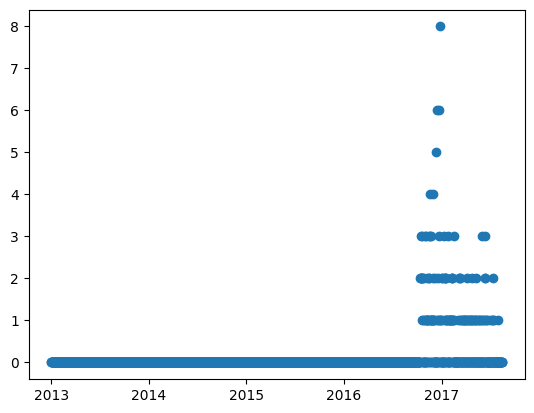

In [ ]:
a = training_dataset[(training_dataset["store_nbr"]==1)&(training_dataset["family"]=="BOOKS")][["date","sales"]]
plt.scatter(x = a["date"], y=a["sales"])